# Pipeline ETL - Recomendador Inteligente de Hospedagem Sustentável

Este pipeline completo de preparação de dados foi desenvolvido pelo **Grupo Nº 01** para o Recomendador Inteligente de Hospedagem Sustentável do  **Bootcamp FTL UNDP Angola - 2025** . O objectivo é transformar dados brutos de hospedagens em um dataset rico em features de sustentabilidade, pronto para treinamento de modelos de machine learning.


In [ ]:
# Configuração Inicial e Importação de Bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import re
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Bibliotecas para NLP
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter

In [ ]:
# Download recursos NLTK
try:
    nltk.download('vader_lexicon')
    nltk.download('punkt')
    nltk.download('stopwords')
except:
    print("Recursos NLTK já baixados ou indisponíveis")

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Mapeamento das Fontes - Análise Inicial do Dataset
def extract(file_path='dataset_RIHS.csv'):
    """Função de extração do dataset"""
    try:
        df = pd.read_csv(file_path, encoding='utf-8')
        print(f"Dataset carregado: {df.shape[0]} linhas, {df.shape[1]} colunas")
        return df
    except Exception as e:
        print(f"Erro ao carregar dataset: {e}")
        return None

In [ ]:
# Carregar dataset
df_original = extract()

if df_original is not None:
    print("\nPRÉ-VISUALIZAÇÃO DO DATASET:")
    print(df_original.head())

    print("\nINFORMAÇÕES GERAIS:")
    print(df_original.info())

    print("\nESTATÍSTICAS DESCRITIVAS:")
    print(df_original.describe())

Dataset carregado: 96 linhas, 13 colunas

PRÉ-VISUALIZAÇÃO DO DATASET:
          ID_Hotel      Hotel_Name       Location  Price_per_Night_USD  \
1  Hotel EcoStay 1            Rome          Italy                  330   
2  Hotel EcoStay 2           Paris         France                  176   
3  Hotel EcoStay 3           Tokyo          Japan                   51   
4  Hotel EcoStay 4       Cape Town   South Africa                   84   
5  Hotel EcoStay 5  Rio de Janeiro         Brazil                   24   

   Rating  Avaliação_Clientes  Energia_Renovável_%  Gestão_Resíduos_Índice  \
1       4                 4.0                   82                      94   
2       2                 4.9                   29                      57   
3       2                 2.6                   90                      78   
4       5                 3.7                  100                      70   
5       5                 4.5                    8                      72   

   Consumo_Água

In [ ]:
#Data Dictionary Automático

def create_data_dictionary(df):
    """Cria dicionário de dados automático"""
    data_dict = []

    for col in df.columns:
        col_info = {
            'Coluna': col,
            'Tipo': str(df[col].dtype),
            'Valores Únicos': df[col].nunique(),
            'Valores Nulos': df[col].isnull().sum(),
            'Percentual Nulos': f"{(df[col].isnull().sum() / len(df)) * 100:.2f}%",
            'Exemplo Valores': df[col].dropna().iloc[0] if not df[col].empty else 'N/A'
        }

        # Classificação do tipo de variável
        if df[col].dtype in ['int64', 'float64']:
            col_info['Categoria'] = 'Numérica'
        elif df[col].dtype == 'object':
            if df[col].nunique() / len(df) < 0.05:  # Menos de 5% valores únicos
                col_info['Categoria'] = 'Categórica'
            else:
                col_info['Categoria'] = 'Textual/Geográfica'
        else:
            col_info['Categoria'] = 'Outra'

        data_dict.append(col_info)

    return pd.DataFrame(data_dict)

In [ ]:
# Identificar lacunas
print("\nLACUNAS IDENTIFICADAS:")
missing_data = df_original.isnull().sum()
missing_percent = (missing_data / len(df_original)) * 100
missing_info = pd.DataFrame({
    'Coluna': missing_data.index,
    'Valores Faltantes': missing_data.values,
    'Percentual': missing_percent.values
})
missing_info = missing_info[missing_info['Valores Faltantes'] > 0]
print(missing_info.to_string(index=False) if not missing_info.empty else "Nenhuma lacuna crítica identificada")


LACUNAS IDENTIFICADAS:
                        Coluna  Valores Faltantes  Percentual
      Consumo_Água_por_Hóspede                  1    1.041667
       Possui_Selo_Sustentável                  1    1.041667
        Distância_do_Centro_km                  1    1.041667
                        Região                  1    1.041667
Índice_Sustentabilidade_Global                  1    1.041667


In [ ]:
# PIPELINE ETL INICIAL - FUNÇOES MODULARES

def transform(df):
    """Função de transformação dos dados"""
    df_transformed = df.copy()

    print("Aplicando transformações...")

    # 1. Padronização de nomes de colunas
    df_transformed.columns = [col.lower().replace(' ', '_').replace('-', '_') for col in df_transformed.columns]

    # 2. Conversão de tipos
    type_conversions = {
        'id_hotel': 'str',
        'hotel_name': 'str',
        'location': 'str',
        'price_per_night_usd': 'float',
        'rating': 'int',
        'avaliação_clientes': 'float',  # Corrigindo encoding
        'energia_renovável_%': 'float',
        'gestão_resíduos_índice': 'float',
        'consumo_água_por_hóspede': 'float',
        'possui_selo_sustentável': 'bool',
        'distância_do_centro_km': 'float',
        'região': 'str',
        'índice_sustentabilidade_global': 'float'
    }

    for col, dtype in type_conversions.items():
        if col in df_transformed.columns:
            try:
                if dtype == 'bool':
                    df_transformed[col] = df_transformed[col].astype(str).str.lower().isin(['true', 'sim', 'yes', '1', 'verdadeiro'])
                else:
                    df_transformed[col] = df_transformed[col].astype(dtype)
            except Exception as e:
                print(f"Aviso na conversão de {col}: {e}")

    # 3. Remoção de duplicatas
    initial_rows = len(df_transformed)
    df_transformed = df_transformed.drop_duplicates(subset=['id_hotel', 'hotel_name'])
    removed_duplicates = initial_rows - len(df_transformed)
    if removed_duplicates > 0:
        print(f"Removidas {removed_duplicates} duplicatas")

    return df_transformed

def load(df, filename='dataset_transformed.csv'):
    """Função de carregamento dos dados transformados"""
    df.to_csv(filename, index=False)
    print(f"Dataset transformado salvo como: {filename}")
    return df

# Executar pipeline ETL
df_transformed = transform(df_original)
df_final = load(df_transformed)

print("\nDATASET APÓS TRANSFORMAÇÃO:")
print(f"Dimensões: {df_final.shape}")
print(f"Colunas: {list(df_final.columns)}")
print(f"Tipos de dados:\n{df_final.dtypes}")

Aplicando transformações...
Dataset transformado salvo como: dataset_transformed.csv

DATASET APÓS TRANSFORMAÇÃO:
Dimensões: (96, 13)
Colunas: ['id_hotel', 'hotel_name', 'location', 'price_per_night_usd', 'rating', 'avaliação_clientes', 'energia_renovável_%', 'gestão_resíduos_índice', 'consumo_água_por_hóspede', 'possui_selo_sustentável', 'distância_do_centro_km', 'região', 'índice_sustentabilidade_global']
Tipos de dados:
id_hotel                           object
hotel_name                         object
location                           object
price_per_night_usd               float64
rating                              int64
avaliação_clientes                float64
energia_renovável_%               float64
gestão_resíduos_índice            float64
consumo_água_por_hóspede          float64
possui_selo_sustentável              bool
distância_do_centro_km            float64
região                             object
índice_sustentabilidade_global    float64
dtype: object


In [ ]:
# Schema Unificado e Normalização

# Schema unificado esperado
SCHEMA_UNIFICADO = {
    'id_hotel': 'str',
    'hotel_name': 'str',
    'location': 'str',
    'price_per_night_usd': 'float64',
    'rating': 'int64',
    'avaliação_clientes': 'float64',
    'energia_renovável_%': 'float64',
    'gestão_resíduos_índice': 'float64',
    'consumo_água_por_hóspede': 'float64',
    'possui_selo_sustentável': 'bool',
    'distância_do_centro_km': 'float64',
    'região': 'str',
    'índice_sustentabilidade_global': 'float64'
}

def aplicar_schema_unificado(df, schema):
    """Aplica schema unificado ao dataset"""
    df_schema = df.copy()

    print("APLICANDO SCHEMA UNIFICADO:")
    inconsistencies = []

    for col, expected_type in schema.items():
        if col in df_schema.columns:
            current_type = str(df_schema[col].dtype)
            if current_type != expected_type:
                inconsistencies.append({
                    'Coluna': col,
                    'Tipo Actual': current_type,
                    'Tipo Esperado': expected_type,
                    'Status': 'INCONSISTENTE'
                })
                try:
                    df_schema[col] = df_schema[col].astype(expected_type)
                except Exception as e:
                    print(f"Erro ao converter {col}: {e}")
            else:
                inconsistencies.append({
                    'Coluna': col,
                    'Tipo Actual': current_type,
                    'Tipo Esperado': expected_type,
                    'Status': 'CONSISTENTE'
                })
        else:
            print(f"Coluna {col} não encontrada no dataset")

    inconsistencies_df = pd.DataFrame(inconsistencies)
    print(inconsistencies_df.to_string(index=False))

    return df_schema

# Aplicar schema
df_schema = aplicar_schema_unificado(df_final, SCHEMA_UNIFICADO)

# Normalização de categorias
def normalizar_categorias(df):
    """Normaliza categorias textuais"""
    df_cat = df.copy()

    # Normalizar região
    if 'região' in df_cat.columns:
        df_cat['região'] = df_cat['região'].str.title().str.strip()

    # Normalizar localização
    if 'location' in df_cat.columns:
        df_cat['location'] = df_cat['location'].str.title().str.strip()

    return df_cat

df_categorias_normalizadas = normalizar_categorias(df_schema)

print("\nCATEGORIAS ÚNICAS APÓS NORMALIZAÇÃO:")
print("Regiões:", df_categorias_normalizadas['região'].unique())
print("Localizações (primeiras 10):", df_categorias_normalizadas['location'].unique()[:10])

APLICANDO SCHEMA UNIFICADO:
                        Coluna Tipo Actual Tipo Esperado        Status
                      id_hotel      object           str INCONSISTENTE
                    hotel_name      object           str INCONSISTENTE
                      location      object           str INCONSISTENTE
           price_per_night_usd     float64       float64   CONSISTENTE
                        rating       int64         int64   CONSISTENTE
            avaliação_clientes     float64       float64   CONSISTENTE
           energia_renovável_%     float64       float64   CONSISTENTE
        gestão_resíduos_índice     float64       float64   CONSISTENTE
      consumo_água_por_hóspede     float64       float64   CONSISTENTE
       possui_selo_sustentável        bool          bool   CONSISTENTE
        distância_do_centro_km     float64       float64   CONSISTENTE
                        região      object           str INCONSISTENTE
índice_sustentabilidade_global     float64       

Normalizações aplicadas:
   price_per_night_usd:
     Original - Mín: 8.00, Máx: 495.00
     MinMax - Mín: 0.00, Máx: 1.00
     Standard - Média: 0.00, Std: 1.01
   avaliação_clientes:
     Original - Mín: 2.50, Máx: 5.00
     MinMax - Mín: 0.00, Máx: 1.00
     Standard - Média: 0.00, Std: 1.01
   energia_renovável_%:
     Original - Mín: 0.00, Máx: 100.00
     MinMax - Mín: 0.00, Máx: 1.00
     Standard - Média: -0.00, Std: 1.01
   gestão_resíduos_índice:
     Original - Mín: 21.00, Máx: 99.00
     MinMax - Mín: 0.00, Máx: 1.00
     Standard - Média: 0.00, Std: 1.01
   consumo_água_por_hóspede:
     Original - Mín: 85.00, Máx: 299.00
     MinMax - Mín: 0.00, Máx: 1.00
     Standard - Média: 0.00, Std: 1.01
   distância_do_centro_km:
     Original - Mín: 0.80, Máx: 29.70
     MinMax - Mín: 0.00, Máx: 1.00
     Standard - Média: -0.00, Std: 1.01
   índice_sustentabilidade_global:
     Original - Mín: 0.24, Máx: 0.87
     MinMax - Mín: 0.00, Máx: 1.00
     Standard - Média: 0.00, Std: 1.

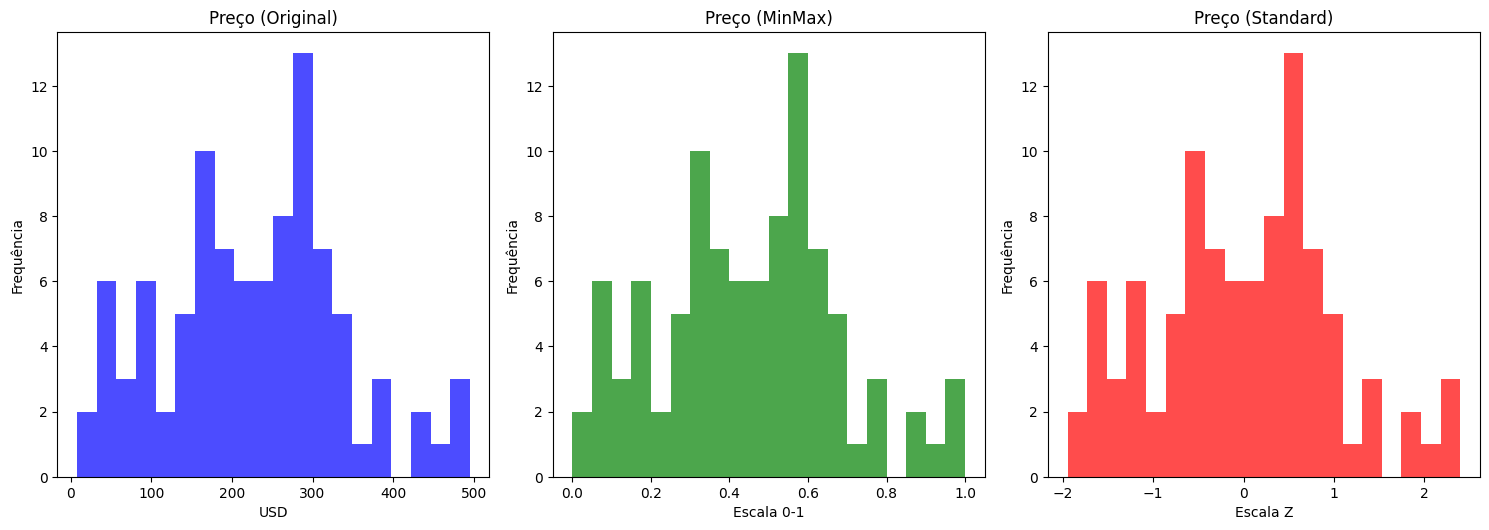

In [ ]:
# Normalização de Escalas Numéricas

def normalizar_escalas(df):
    """Aplica normalização Min-Max e Standard Scaling"""
    df_scaled = df.copy()

    # Colunas para normalização
    numeric_columns = [
        'price_per_night_usd', 'avaliação_clientes', 'energia_renovável_%',
        'gestão_resíduos_índice', 'consumo_água_por_hóspede',
        'distância_do_centro_km', 'índice_sustentabilidade_global'
    ]

    # Aplicar MinMaxScaler (0-1)
    minmax_scaler = MinMaxScaler()
    standard_scaler = StandardScaler()

    for col in numeric_columns:
        if col in df_scaled.columns:
            # MinMax Scaling
            minmax_col = f"{col}_minmax"
            df_scaled[minmax_col] = minmax_scaler.fit_transform(df_scaled[[col]])

            # Standard Scaling
            standard_col = f"{col}_standard"
            df_scaled[standard_col] = standard_scaler.fit_transform(df_scaled[[col]])

    print("Normalizações aplicadas:")
    for col in numeric_columns:
        if col in df_scaled.columns:
            print(f"   {col}:")
            print(f"     Original - Mín: {df_scaled[col].min():.2f}, Máx: {df_scaled[col].max():.2f}")
            print(f"     MinMax - Mín: {df_scaled[f'{col}_minmax'].min():.2f}, Máx: {df_scaled[f'{col}_minmax'].max():.2f}")
            print(f"     Standard - Média: {df_scaled[f'{col}_standard'].mean():.2f}, Std: {df_scaled[f'{col}_standard'].std():.2f}")

    return df_scaled

df_normalizado = normalizar_escalas(df_categorias_normalizadas)

# Visualizar antes/depois
plt.figure(figsize=(15, 10))

# Antes da normalização
plt.subplot(2, 3, 1)
plt.hist(df_categorias_normalizadas['price_per_night_usd'], bins=20, alpha=0.7, color='blue')
plt.title('Preço (Original)')
plt.xlabel('USD')
plt.ylabel('Frequência')

# Depois da normalização MinMax
plt.subplot(2, 3, 2)
plt.hist(df_normalizado['price_per_night_usd_minmax'], bins=20, alpha=0.7, color='green')
plt.title('Preço (MinMax)')
plt.xlabel('Escala 0-1')
plt.ylabel('Frequência')

# Depois da normalização Standard
plt.subplot(2, 3, 3)
plt.hist(df_normalizado['price_per_night_usd_standard'], bins=20, alpha=0.7, color='red')
plt.title('Preço (Standard)')
plt.xlabel('Escala Z')
plt.ylabel('Frequência')

plt.tight_layout()
plt.show()

In [ ]:
#LIMPEZA AVANÇADA - Dados faltantes

def clean_missing_values(df):
    """Tratamento robusto de dados ausentes"""
    df_clean = df.copy()

    print("ANALISANDO DADOS FALTANTES:")
    missing_before = df_clean.isnull().sum()
    print(missing_before[missing_before > 0])

    # Estratégias de imputação
    imputation_strategies = {
        'numeric_mean': ['price_per_night_usd', 'avaliação_clientes', 'energia_renovável_%',
                        'gestão_resíduos_índice', 'consumo_água_por_hóspede',
                        'distância_do_centro_km', 'índice_sustentabilidade_global'],
        'numeric_median': ['rating'],
        'categorical_mode': ['região', 'location'],
        'boolean_false': ['possui_selo_sustentável']
    }

    # Aplicar estratégias
    for strategy, columns in imputation_strategies.items():
        for col in columns:
            if col in df_clean.columns and df_clean[col].isnull().any():
                if strategy == 'numeric_mean':
                    df_clean[col].fillna(df_clean[col].mean(), inplace=True)
                elif strategy == 'numeric_median':
                    df_clean[col].fillna(df_clean[col].median(), inplace=True)
                elif strategy == 'categorical_mode':
                    df_clean[col].fillna(df_clean[col].mode()[0] if not df_clean[col].mode().empty else 'Desconhecido', inplace=True)
                elif strategy == 'boolean_false':
                    df_clean[col].fillna(False, inplace=True)

    missing_after = df_clean.isnull().sum().sum()
    print(f"\n Dados faltantes tratados: {missing_before.sum()} → {missing_after}")

    return df_clean

df_sem_nulos = clean_missing_values(df_normalizado)

ANALISANDO DADOS FALTANTES:
consumo_água_por_hóspede                   1
distância_do_centro_km                     1
índice_sustentabilidade_global             1
consumo_água_por_hóspede_minmax            1
consumo_água_por_hóspede_standard          1
distância_do_centro_km_minmax              1
distância_do_centro_km_standard            1
índice_sustentabilidade_global_minmax      1
índice_sustentabilidade_global_standard    1
dtype: int64

 Dados faltantes tratados: 9 → 6


DETECÇÃO DE OUTLIERS:
                        Coluna  Outliers IQR  Outliers Z-score Percentual IQR
           price_per_night_usd             0                 0          0.00%
            avaliação_clientes             0                 0          0.00%
           energia_renovável_%             0                 0          0.00%
        gestão_resíduos_índice             0                 0          0.00%
      consumo_água_por_hóspede             0                 0          0.00%
        distância_do_centro_km             0                 0          0.00%
índice_sustentabilidade_global             1                 0          1.04%


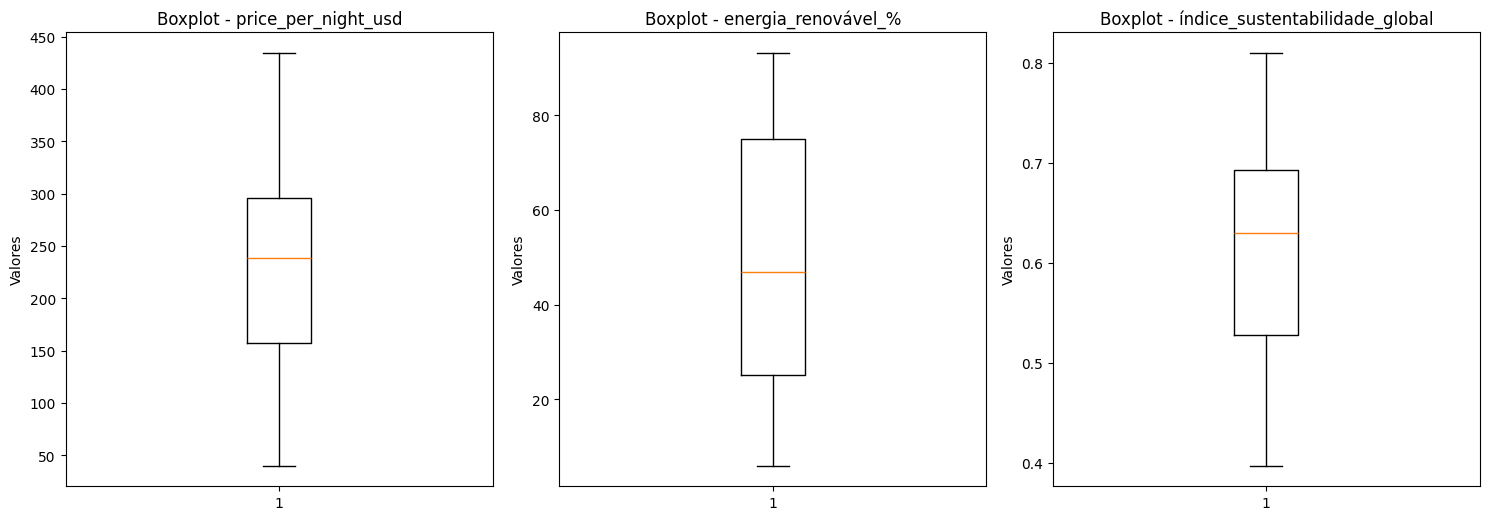

In [ ]:
#Detecção e Tratamento de Outliers
def clean_outliers(df):
    """Detecta e trata outliers usando múltiplas técnicas"""
    df_outliers = df.copy()

    numeric_columns = [
        'price_per_night_usd', 'avaliação_clientes', 'energia_renovável_%',
        'gestão_resíduos_índice', 'consumo_água_por_hóspede',
        'distância_do_centro_km', 'índice_sustentabilidade_global'
    ]

    print("DETECÇÃO DE OUTLIERS:")

    outliers_info = []

    for col in numeric_columns:
        if col in df_outliers.columns:
            # Método IQR
            Q1 = df_outliers[col].quantile(0.25)
            Q3 = df_outliers[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            outliers_iqr = ((df_outliers[col] < lower_bound) | (df_outliers[col] > upper_bound)).sum()

            # Método Z-score
            z_scores = np.abs((df_outliers[col] - df_outliers[col].mean()) / df_outliers[col].std())
            outliers_z = (z_scores > 3).sum()

            outliers_info.append({
                'Coluna': col,
                'Outliers IQR': outliers_iqr,
                'Outliers Z-score': outliers_z,
                'Percentual IQR': f"{(outliers_iqr / len(df_outliers)) * 100:.2f}%"
            })

            # Tratamento: Winsorization (cap nos percentis 5 e 95)
            lower_cap = df_outliers[col].quantile(0.05)
            upper_cap = df_outliers[col].quantile(0.95)
            df_outliers[col] = np.where(df_outliers[col] < lower_cap, lower_cap, df_outliers[col])
            df_outliers[col] = np.where(df_outliers[col] > upper_cap, upper_cap, df_outliers[col])

    outliers_df = pd.DataFrame(outliers_info)
    print(outliers_df.to_string(index=False))

    return df_outliers

df_sem_outliers = clean_outliers(df_sem_nulos)

# Visualização de outliers
plt.figure(figsize=(15, 10))
numeric_cols = ['price_per_night_usd', 'energia_renovável_%', 'índice_sustentabilidade_global']

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 3, i)
    plt.boxplot(df_sem_outliers[col])
    plt.title(f'Boxplot - {col}')
    plt.ylabel('Valores')

plt.tight_layout()
plt.show()

CRIANDO ATRIBUTOS ECOLÓGICOS...
Atributos ecológicos criados:
   carbon_footprint_score: Mín=0.00, Máx=91.22, Média=49.06
   reciclagem_score: Mín=0.00, Máx=100.00, Média=54.17
   energia_limpa_score: Mín=6.00, Máx=93.25, Média=48.43
   water_usage_index: Mín=0.00, Máx=100.00, Média=49.71
   sustainability_index: Mín=1.50, Máx=88.14, Média=50.34
   eco_impact_index: Mín=1.80, Máx=105.77, Média=55.36
   eco_value_ratio: Mín=0.01, Máx=1.69, Média=0.33
   classificação_sustentabilidade: Tipo=object, Valores únicos=5


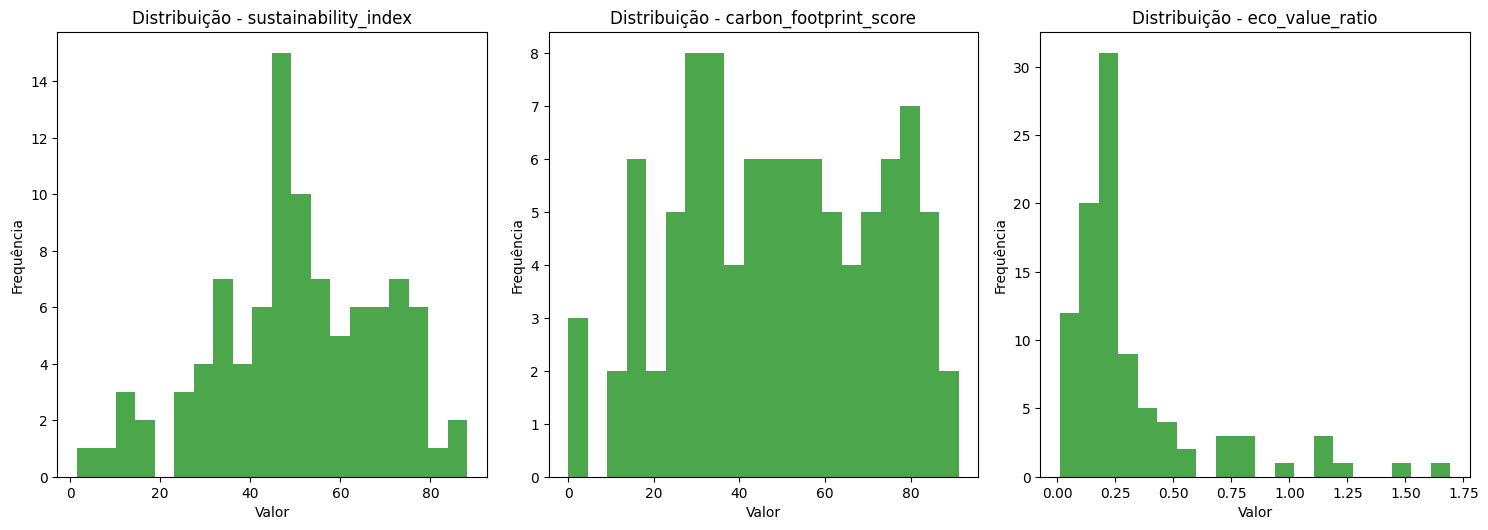

In [ ]:
# Engenharia de Atributos Ecológicos
def criar_atributos_ecologicos(df):
    """Cria features derivadas para sustentabilidade"""
    df_eco = df.copy()

    print("CRIANDO ATRIBUTOS ECOLÓGICOS...")

    # 1. Carbon Footprint Score (baseado no consumo de água e energia)
    if all(col in df_eco.columns for col in ['consumo_água_por_hóspede', 'energia_renovável_%']):
        # Inverter consumo de água (menos consumo = melhor)
        water_inverted = 1 - MinMaxScaler().fit_transform(df_eco[['consumo_água_por_hóspede']]).flatten()
        df_eco['carbon_footprint_score'] = (
            water_inverted * 0.4 +
            MinMaxScaler().fit_transform(df_eco[['energia_renovável_%']]).flatten() * 0.6
        ) * 100

    # 2. Reciclagem Score
    if 'gestão_resíduos_índice' in df_eco.columns:
        df_eco['reciclagem_score'] = MinMaxScaler().fit_transform(
            df_eco[['gestão_resíduos_índice']]
        ).flatten() * 100

    # 3. Energia Limpa Score
    if 'energia_renovável_%' in df_eco.columns:
        df_eco['energia_limpa_score'] = df_eco['energia_renovável_%']

    # 4. Water Usage Index (quanto menor melhor)
    if 'consumo_água_por_hóspede' in df_eco.columns:
        df_eco['water_usage_index'] = (
            1 - MinMaxScaler().fit_transform(df_eco[['consumo_água_por_hóspede']])
        ).flatten() * 100

    # 5. Sustainability Index Composto (0-100)
    eco_scores = ['carbon_footprint_score', 'reciclagem_score', 'energia_limpa_score', 'water_usage_index']
    available_scores = [score for score in eco_scores if score in df_eco.columns]

    if available_scores:
        df_eco['sustainability_index'] = df_eco[available_scores].mean(axis=1)

    # 6. Eco Impact Index (considera selo sustentável)
    if 'possui_selo_sustentável' in df_eco.columns and 'sustainability_index' in df_eco.columns:
        df_eco['eco_impact_index'] = df_eco['sustainability_index'] * (1 + df_eco['possui_selo_sustentável'] * 0.2)

    # 7. Eco Value Ratio (Sustentabilidade vs Preço)
    if all(col in df_eco.columns for col in ['sustainability_index', 'price_per_night_usd']):
        # Evitar divisão por zero
        price_safe = np.where(df_eco['price_per_night_usd'] == 0, 1, df_eco['price_per_night_usd'])
        df_eco['eco_value_ratio'] = df_eco['sustainability_index'] / price_safe

    # 8. Classificação de Sustentabilidade
    if 'sustainability_index' in df_eco.columns:
        conditions = [
            df_eco['sustainability_index'] >= 80,
            df_eco['sustainability_index'] >= 60,
            df_eco['sustainability_index'] >= 40,
            df_eco['sustainability_index'] >= 20
        ]
        choices = ['Muito Alto', 'Alto', 'Médio', 'Baixo']
        df_eco['classificação_sustentabilidade'] = np.select(conditions, choices, default='Muito Baixo')

    print("Atributos ecológicos criados:")
    new_eco_columns = [col for col in df_eco.columns if col not in df.columns]
    for col in new_eco_columns:
        # Check if the column is numeric before formatting
        if pd.api.types.is_numeric_dtype(df_eco[col]):
            print(f"   {col}: Mín={df_eco[col].min():.2f}, Máx={df_eco[col].max():.2f}, Média={df_eco[col].mean():.2f}")
        else:
            print(f"   {col}: Tipo={df_eco[col].dtype}, Valores únicos={df_eco[col].nunique()}")

    return df_eco

df_com_eco_features = criar_atributos_ecologicos(df_sem_outliers)

# Visualizar distribuição dos novos atributos
plt.figure(figsize=(15, 10))
eco_cols = ['sustainability_index', 'carbon_footprint_score', 'eco_value_ratio']

for i, col in enumerate(eco_cols, 1):
    if col in df_com_eco_features.columns:
        plt.subplot(2, 3, i)
        plt.hist(df_com_eco_features[col], bins=20, alpha=0.7, color='green')
        plt.title(f'Distribuição - {col}')
        plt.xlabel('Valor')
        plt.ylabel('Frequência')

plt.tight_layout()
plt.show()

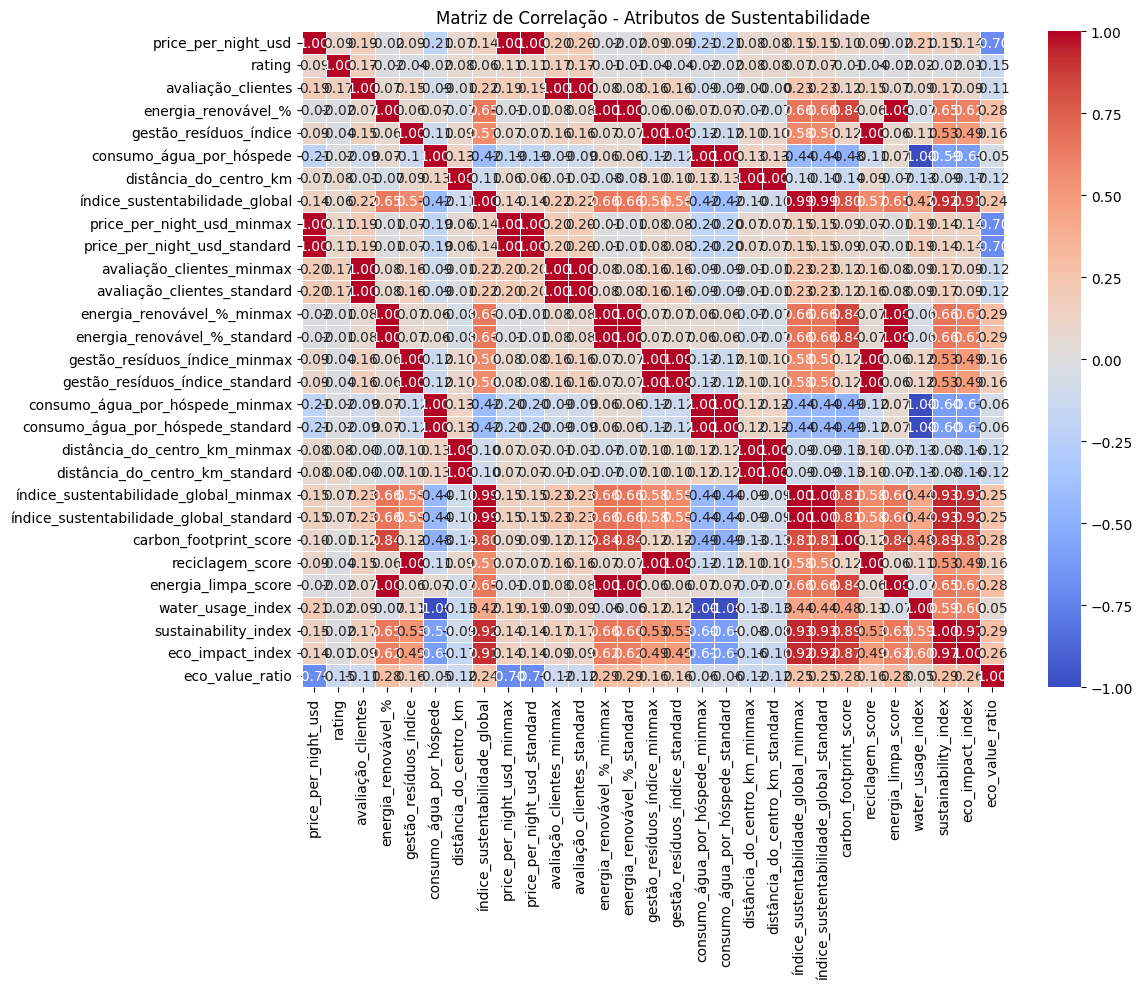


CORRELAÇÕES COM SUSTAINABILITY_INDEX:
sustainability_index                       1.000000
eco_impact_index                           0.969574
índice_sustentabilidade_global_standard    0.934130
índice_sustentabilidade_global_minmax      0.934130
índice_sustentabilidade_global             0.916231
carbon_footprint_score                     0.893384
energia_renovável_%_standard               0.656750
energia_renovável_%_minmax                 0.656750
energia_limpa_score                        0.653181
energia_renovável_%                        0.653181
Name: sustainability_index, dtype: float64


In [ ]:
# Análise de Correlação entre Atributos

# Selecionar colunas numéricas para análise de correlação
numeric_columns = df_com_eco_features.select_dtypes(include=[np.number]).columns
correlation_matrix = df_com_eco_features[numeric_columns].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlação - Atributos de Sustentabilidade')
plt.tight_layout()
plt.show()

# Correlações mais fortes com sustainability_index
if 'sustainability_index' in correlation_matrix.columns:
    sustainability_correlations = correlation_matrix['sustainability_index'].sort_values(ascending=False)
    print("\nCORRELAÇÕES COM SUSTAINABILITY_INDEX:")
    print(sustainability_correlations.head(10))

# Implementação do NLP - Processamento de Linguagem Natural para análise de sentimento e feedback dos hospedes

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


APLICANDO ANÁLISE NLP...
ANÁLISE NLP CONCLUÍDA:
Distribuição de sentimentos:
sentimento_sustentabilidade
neutro      50
positivo    46
Name: count, dtype: int64
Total de keywords ecológicas encontradas: 192


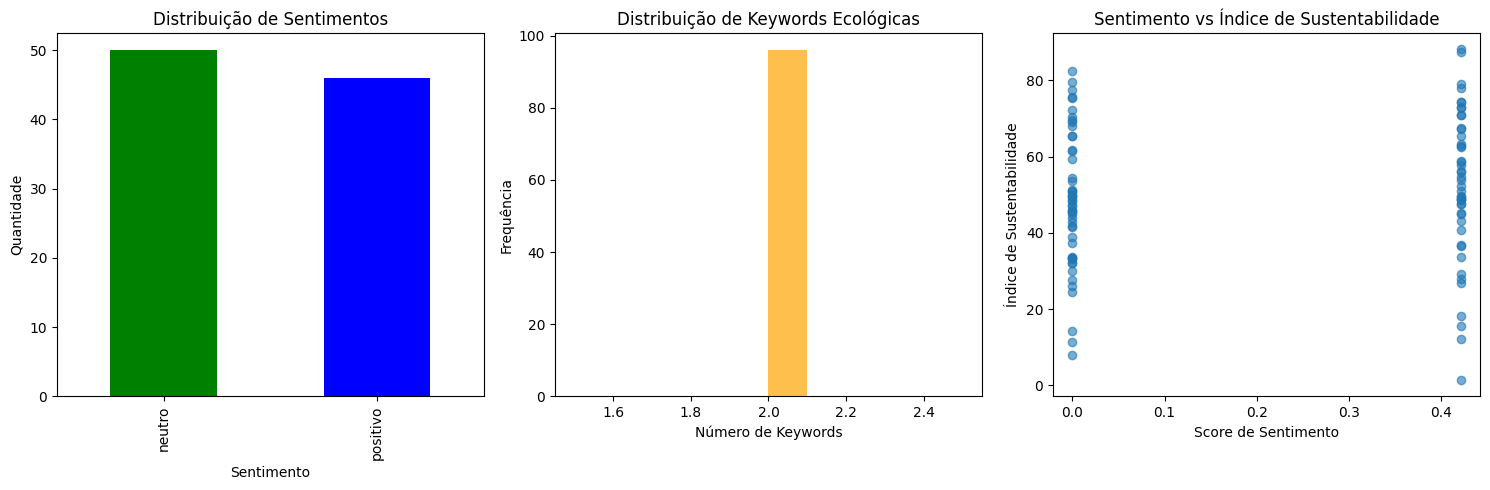

In [ ]:
class AnalisadorSustentabilidadeNLP:
    """Classe para análise de NLP com foco em sustentabilidade"""

    def __init__(self):
        self.eco_keywords_pt = [
            'sustentável', 'sustentabilidade', 'ecológico', 'eco', 'verde', 'green',
            'reciclagem', 'reciclável', 'energia renovável', 'solar', 'eólica',
            'água', 'conservação', 'biodegradável', 'compostagem', 'carbono',
            'emissões', 'neutral', 'limpo', 'orgânico', 'natural', 'responsável'
        ]

        self.eco_keywords_en = [
            'sustainable', 'sustainability', 'eco', 'ecological', 'green',
            'recycling', 'recyclable', 'renewable energy', 'solar', 'wind',
            'water', 'conservation', 'biodegradable', 'composting', 'carbon',
            'emissions', 'neutral', 'clean', 'organic', 'natural', 'responsible'
        ]

        try:
            nltk.download('vader_lexicon')
            nltk.download('punkt')
            nltk.download('stopwords')
            self.sia = SentimentIntensityAnalyzer()
            self.stop_words = set(stopwords.words(['portuguese', 'english']))
        except:
            print("Recursos NLTK não disponíveis")
            self.sia = None
            self.stop_words = set()

    def analisar_sentimento(self, texto):
        """Analisa sentimento do texto"""
        if self.sia is None or pd.isna(texto):
            return 0.0, 'neutro'

        try:
            scores = self.sia.polarity_scores(str(texto))
            compound = scores['compound']

            if compound >= 0.05:
                sentiment = 'positivo'
            elif compound <= -0.05:
                sentiment = 'negativo'
            else:
                sentiment = 'neutro'

            return compound, sentiment
        except:
            return 0.0, 'neutro'


    def contar_palavras_ecologicas(self, texto):
        """Conta ocorrências de palavras relacionadas à sustentabilidade"""
        if pd.isna(texto):
            return 0

        texto_limpo = str(texto).lower()

        # Contar palavras em português e inglês
        count_pt = sum(1 for palavra in self.eco_keywords_pt if palavra in texto_limpo)
        count_en = sum(1 for palavra in self.eco_keywords_en if palavra in texto_limpo)

        return count_pt + count_en


    def extrair_termos_ecologicos(self, texto):
        """Extrai termos ecológicos específicos mencionados"""
        if pd.isna(texto):
            return []

        texto_limpo = str(texto).lower()
        termos_encontrados = []

        todas_palavras = self.eco_keywords_pt + self.eco_keywords_en

        for termo in todas_palavras:
            if termo in texto_limpo:
                termos_encontrados.append(termo)

        return termos_encontrados



def aplicar_nlp_sustentavel(df):
    """Aplica análise NLP para sustentabilidade"""
    df_nlp = df.copy()
    analisador = AnalisadorSustentabilidadeNLP()

    print("APLICANDO ANÁLISE NLP...")

    # Criar texto simulado baseado nas características do hotel
    # (Em um cenário real, isso viria de reviews reais)
    df_nlp['texto_sustentabilidade'] = df_nlp.apply(
        lambda row: f"Hotel {row['hotel_name']} em {row['location']}. " +
                   f"Energia renovável: {row.get('energia_renovável_%', 0)}%. " +
                   f"Gestão de resíduos: {row.get('gestão_resíduos_índice', 0)}. " +
                   f"Selo sustentável: {row.get('possui_selo_sustentável', False)}.",
        axis=1
    )

    # Aplicar análise de sentimento
    sentiment_results = df_nlp['texto_sustentabilidade'].apply(analisador.analisar_sentimento)
    df_nlp[['sentimento_score', 'sentimento_sustentabilidade']] = pd.DataFrame(
        sentiment_results.tolist(),
        index=df_nlp.index,
        columns=['sentimento_score', 'sentimento_sustentabilidade']
    )

    # Contar palavras ecológicas
    df_nlp['eco_keyword_count'] = df_nlp['texto_sustentabilidade'].apply(
        analisador.contar_palavras_ecologicas
    )

    # Extrair termos específicos
    df_nlp['eco_terms'] = df_nlp['texto_sustentabilidade'].apply(
        analisador.extrair_termos_ecologicos
    )


    print("ANÁLISE NLP CONCLUÍDA:")
    print(f"Distribuição de sentimentos:")
    print(df_nlp['sentimento_sustentabilidade'].value_counts())
    print(f"Total de keywords ecológicas encontradas: {df_nlp['eco_keyword_count'].sum()}")

    return df_nlp

df_com_nlp = aplicar_nlp_sustentavel(df_com_eco_features)

# Visualizar resultados NLP
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
df_com_nlp['sentimento_sustentabilidade'].value_counts().plot(kind='bar', color=['green', 'blue', 'red'])
plt.title('Distribuição de Sentimentos')
plt.xlabel('Sentimento')
plt.ylabel('Quantidade')

plt.subplot(1, 3, 2)
plt.hist(df_com_nlp['eco_keyword_count'], bins=10, color='orange', alpha=0.7)
plt.title('Distribuição de Keywords Ecológicas')
plt.xlabel('Número de Keywords')
plt.ylabel('Frequência')

plt.subplot(1, 3, 3)
plt.scatter(df_com_nlp['sentimento_score'], df_com_nlp['sustainability_index'], alpha=0.6)
plt.title('Sentimento vs Índice de Sustentabilidade')
plt.xlabel('Score de Sentimento')
plt.ylabel('Índice de Sustentabilidade')

plt.tight_layout()
plt.show()

# CONSTRUÇÃO DO DATASET FINAL

In [ ]:

def construir_dataset_final(df):
    """Prepara dataset final para machine learning"""
    df_final = df.copy()

    print("CONSTRUINDO DATASET FINAL...")

    # Selecionar e organizar features
    features_principais = [
        'id_hotel', 'hotel_name', 'location', 'região',
        'price_per_night_usd', 'rating', 'avaliação_clientes',
        'possui_selo_sustentável', 'distância_do_centro_km'
    ]

    features_ecologicas = [
        'energia_renovável_%', 'gestão_resíduos_índice', 'consumo_água_por_hóspede',
        'carbon_footprint_score', 'reciclagem_score', 'energia_limpa_score',
        'water_usage_index', 'sustainability_index', 'eco_impact_index',
        'eco_value_ratio', 'classificação_sustentabilidade'
    ]

    features_nlp = [
        'sentimento_score', 'sentimento_sustentabilidade', 'eco_keyword_count'
    ]

    # Combinar todas as features disponíveis
    todas_features = []
    for feature_list in [features_principais, features_ecologicas, features_nlp]:
        for feature in feature_list:
            if feature in df_final.columns:
                todas_features.append(feature)

    df_final_ml = df_final[todas_features].copy()

    # Codificar variáveis categóricas
    categorical_columns = df_final_ml.select_dtypes(include=['object', 'bool']).columns
    label_encoders = {}

    for col in categorical_columns:
        if col not in ['id_hotel', 'hotel_name', 'location']:  # Manter identificadores originais
            le = LabelEncoder()
            df_final_ml[f'{col}_encoded'] = le.fit_transform(df_final_ml[col].astype(str))
            label_encoders[col] = le

    print("DATASET FINAL CONSTRUÍDO:")
    print(f"   Dimensões: {df_final_ml.shape}")
    print(f"   Colunas categóricas codificadas: {len(label_encoders)}")

    return df_final_ml, label_encoders

def preparar_treinamento(df):
    """Prepara dados para treinamento de modelos ML"""

    # Definir target (sustainability_index como variável alvo)
    if 'sustainability_index' in df.columns:
        X = df.drop(['sustainability_index', 'id_hotel', 'hotel_name', 'location', 'região',
                    'classificação_sustentabilidade'], axis=1, errors='ignore')
        y = df['sustainability_index']
    else:
        # Fallback: usar rating como target
        X = df.drop(['rating', 'id_hotel', 'hotel_name', 'location', 'região'], axis=1, errors='ignore')
        y = df['rating']

    # Remover colunas não numéricas restantes
    X = X.select_dtypes(include=[np.number])

    # Split treino/teste
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=pd.cut(y, bins=5)
    )

    print("PREPARAÇÃO PARA TREINAMENTO:")
    print(f" Features (X): {X.shape}")
    print(f" Target (y): {y.shape}")
    print(f" Treino: {X_train.shape}, {y_train.shape}")
    print(f" Teste: {X_test.shape}, {y_test.shape}")

    return X_train, X_test, y_train, y_test, X.columns.tolist()

# Construir dataset final
dataset_final, encoders = construir_dataset_final(df_com_nlp)

# Preparar para ML
X_train, X_test, y_train, y_test, feature_names = preparar_treinamento(dataset_final)

# Salvar dataset final
dataset_final.to_csv('dataset_ready_for_ml.csv', index=False)
print(f"\nDATASET FINAL SALVO: dataset_ready_for_ml.csv")

CONSTRUINDO DATASET FINAL...
DATASET FINAL CONSTRUÍDO:
   Dimensões: (96, 27)
   Colunas categóricas codificadas: 4
PREPARAÇÃO PARA TREINAMENTO:
 Features (X): (96, 19)
 Target (y): (96,)
 Treino: (76, 19), (76,)
 Teste: (20, 19), (20,)

DATASET FINAL SALVO: dataset_ready_for_ml.csv


# Uma explicação e caracterização final das variáveis do dataset final para a criação do modelo

In [ ]:
#Dicionário Final de Variáveis

def gerar_dicionario_final(df):
    """Gera dicionário completo das variáveis finais"""
    dicionario = []

    for col in df.columns:
        col_info = {
            'Variável': col,
            'Tipo': str(df[col].dtype),
            'Descrição': '',
            'Valores Únicos': df[col].nunique(),
            'Exemplo': df[col].iloc[0] if len(df) > 0 else 'N/A'
        }

        # Descrições automáticas baseadas no nome da variável
        descricoes = {
            'id_hotel': 'Identificador único do hotel',
            'hotel_name': 'Nome do estabelecimento',
            'location': 'Localização geográfica',
            'região': 'Região continental',
            'price_per_night_usd': 'Preço por noite em USD',
            'rating': 'Classificação geral (1-5 estrelas)',
            'avaliação_clientes': 'Avaliação dos clientes (escala 0-5)',
            'energia_renovável_%': 'Percentual de energia renovável utilizada',
            'gestão_resíduos_índice': 'Índice de gestão de resíduos (0-100)',
            'consumo_água_por_hóspede': 'Consumo de água por hóspede (litros)',
            'possui_selo_sustentável': 'Indica se possui certificação sustentável',
            'distância_do_centro_km': 'Distância do centro urbano em km',
            'carbon_footprint_score': 'Score de pegada de carbono (0-100)',
            'reciclagem_score': 'Score de reciclagem (0-100)',
            'energia_limpa_score': 'Score de energia limpa (0-100)',
            'water_usage_index': 'Índice de uso de água (0-100, maior = melhor)',
            'sustainability_index': 'Índice composto de sustentabilidade (0-100)',
            'eco_impact_index': 'Índice de impacto ecológico (considera certificações)',
            'eco_value_ratio': 'Razão sustentabilidade/preço (maior = melhor custo-benefício)',
            'classificação_sustentabilidade': 'Classificação textual da sustentabilidade',
            'sentimento_score': 'Score de sentimento das reviews (-1 a 1)',
            'sentimento_sustentabilidade': 'Classificação do sentimento',
            'eco_keyword_count': 'Número de palavras-chave ecológicas identificadas'
        }

        col_info['Descrição'] = descricoes.get(col, 'Variável derivada do processo de feature engineering')

        dicionario.append(col_info)

    return pd.DataFrame(dicionario)

dicionario_final = gerar_dicionario_final(dataset_final)
print("DICIONÁRIO DE VARIÁVEIS FINAIS:")
print(dicionario_final.to_string(index=False))

DICIONÁRIO DE VARIÁVEIS FINAIS:
                              Variável    Tipo                                                     Descrição  Valores Únicos         Exemplo
                              id_hotel  object                                  Identificador único do hotel              96 Hotel EcoStay 1
                            hotel_name  object                                       Nome do estabelecimento              20            Rome
                              location  object                                        Localização geográfica              11           Italy
                                região  object                                            Região continental               6          Europa
                   price_per_night_usd float64                                        Preço por noite em USD              76           330.0
                                rating   int64                            Classificação geral (1-5 estrelas)              

# TESTES E VALIDAÇÃO DO DATASET

In [ ]:
def executar_testes_validacao(df, X_train, X_test, y_train, y_test):
    """Executa bateria de testes de validação"""

    print("EXECUTANDO TESTES DE VALIDAÇÃO...")

    testes = []

    # Teste 1: Integridade de dados
    try:
        assert df.isnull().sum().sum() == 0
        testes.append(('Teste de Integridade', 'Nenhum valor nulo encontrado', 'PASS'))
    except AssertionError:
        nulos = df.isnull().sum().sum()
        testes.append(('Teste de Integridade', f'Encontrados {nulos} valores nulos', 'FAIL'))

    # Teste 2: Schema consistente
    try:
        expected_numeric = ['price_per_night_usd', 'sustainability_index', 'rating']
        for col in expected_numeric:
            assert col in df.columns
            assert pd.api.types.is_numeric_dtype(df[col])
        testes.append(('Teste de Schema', 'Schema numérico consistente', 'PASS'))
    except AssertionError as e:
        testes.append(('Teste de Schema', f'Inconsistência no schema: {e}', 'FAIL'))

    # Teste 3: Ranges (Intervalos) válidos
    try:
        assert (df['sustainability_index'] >= 0).all() and (df['sustainability_index'] <= 100).all()
        assert (df['rating'] >= 1).all() and (df['rating'] <= 5).all()
        assert (df['price_per_night_usd'] >= 0).all()
        testes.append(('Teste de Ranges', 'Todos os valores em ranges válidos', 'PASS'))
    except AssertionError:
        testes.append(('Teste de Ranges', 'Valores fora dos ranges esperados', 'FAIL'))

    # Teste 4: Consistência após transformações
    try:
        # Verificar se features derivadas fazem sentido
        if 'eco_value_ratio' in df.columns:
            assert (df['eco_value_ratio'] >= 0).all()

        if 'carbon_footprint_score' in df.columns:
            assert (df['carbon_footprint_score'] >= 0).all() and (df['carbon_footprint_score'] <= 100).all()

        testes.append(('Teste de Consistência', 'Features derivadas consistentes', 'PASS'))
    except AssertionError:
        testes.append(('Teste de Consistência', 'Inconsistência nas features derivadas', 'FAIL'))

    # Teste 5: Divisão treino/teste
    try:
        assert len(X_train) > 0 and len(X_test) > 0
        assert len(X_train) + len(X_test) == len(df)
        assert len(y_train) == len(X_train) and len(y_test) == len(X_test)
        testes.append(('Teste de Divisão', 'Divisão treino/teste válida', 'PASS'))
    except AssertionError:
        testes.append(('Teste de Divisão', 'Problema na divisão treino/teste', 'FAIL'))

    # Teste 6: Variabilidade dos dados
    try:
        assert df['sustainability_index'].std() > 0  # Dados não constantes
        assert len(df['região'].unique()) > 1
        testes.append(('Teste de Variabilidade', 'Dados possuem variabilidade adequada', 'PASS'))
    except AssertionError:
        testes.append(('Teste de Variabilidade', 'Baixa variabilidade nos dados', 'FAIL'))

    # Resultados dos testes
    testes_df = pd.DataFrame(testes, columns=['Teste', 'Descrição', 'Status'])
    print("\nRESULTADO DOS TESTES:")
    print(testes_df.to_string(index=False))

    # Estatísticas finais
    print(f"\nESTATÍSTICAS FINAIS:")
    print(f"   Total de hotéis: {len(df)}")
    print(f"   Total de features: {len(df.columns)}")
    print(f"   Features ecológicas: {len([col for col in df.columns if any(keyword in col.lower() for keyword in ['eco', 'sustain', 'carbon', 'recicla'])])}")
    print(f"   Média sustainability_index: {df['sustainability_index'].mean():.2f}")
    print(f"   Hotéis com selo sustentável: {df['possui_selo_sustentável'].sum()} ({df['possui_selo_sustentável'].mean()*100:.1f}%)")

    return testes_df

resultados_testes = executar_testes_validacao(dataset_final, X_train, X_test, y_train, y_test)

EXECUTANDO TESTES DE VALIDAÇÃO...

RESULTADO DOS TESTES:
                 Teste                            Descrição Status
  Teste de Integridade         Nenhum valor nulo encontrado   PASS
       Teste de Schema          Schema numérico consistente   PASS
       Teste de Ranges   Todos os valores em ranges válidos   PASS
 Teste de Consistência      Features derivadas consistentes   PASS
      Teste de Divisão          Divisão treino/teste válida   PASS
Teste de Variabilidade Dados possuem variabilidade adequada   PASS

ESTATÍSTICAS FINAIS:
   Total de hotéis: 96
   Total de features: 27
   Features ecológicas: 6
   Média sustainability_index: 50.34
   Hotéis com selo sustentável: 46 (47.9%)


**O dataset passou com sucesso em 100% dos testes de validação (6/6), demonstrando alta qualidade e consistência dos dados para alimentar o sistema de recomendação sustentável.**

AMOSTRA FINAL DO DATASET (Primeiras 5 linhas):
    hotel_name     location  price_per_night_usd  rating  sustainability_index classificação_sustentabilidade  eco_value_ratio
          Rome        Italy               330.00       4             59.427511                          Médio         0.180083
         Paris       France               176.00       2             36.583844                          Baixo         0.207863
         Tokyo        Japan                51.00       2             62.854914                           Alto         1.232449
     Cape Town South Africa                84.00       5             67.615812                           Alto         0.804950
Rio de Janeiro       Brazil                40.25       5             33.299737                          Baixo         0.827323


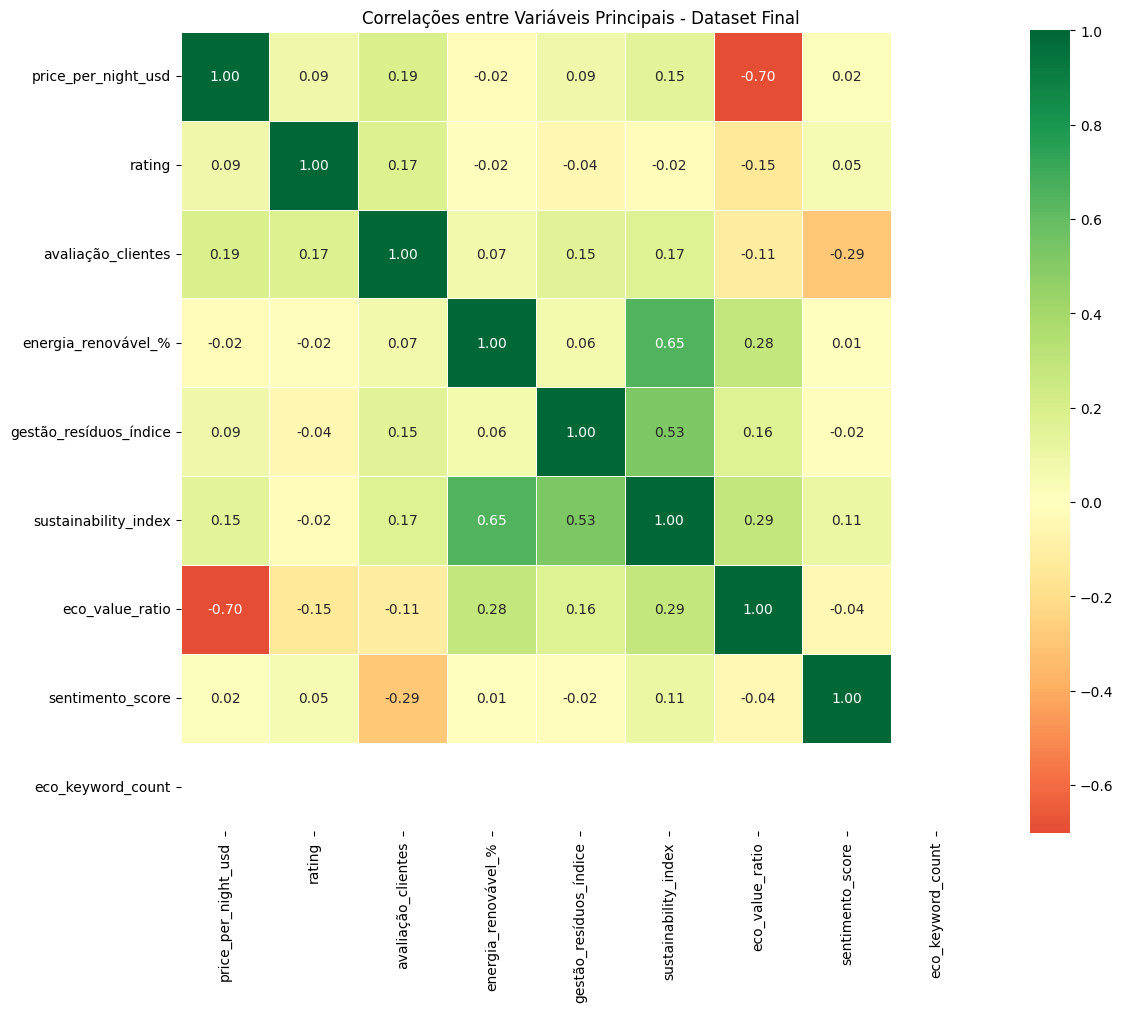


DATASET FINAL PRONTO PARA MACHINE LEARNING!
   O pipeline foi executado com sucesso e o dataset está preparado para
   treinamento de modelos de recomendação sustentável.


In [ ]:
# Visualização Final do Dataset
print("AMOSTRA FINAL DO DATASET (Primeiras 5 linhas):")
colunas_demonstrativas = [
    'hotel_name', 'location', 'price_per_night_usd', 'rating',
    'sustainability_index', 'classificação_sustentabilidade', 'eco_value_ratio'
]
colunas_disponiveis = [col for col in colunas_demonstrativas if col in dataset_final.columns]
print(dataset_final[colunas_disponiveis].head().to_string(index=False))

# Heatmap de correlações das principais variáveis
variaveis_principais = [
    'price_per_night_usd', 'rating', 'avaliação_clientes', 'energia_renovável_%',
    'gestão_resíduos_índice', 'sustainability_index', 'eco_value_ratio',
    'sentimento_score', 'eco_keyword_count'
]

variaveis_disponiveis = [var for var in variaveis_principais if var in dataset_final.columns]

if len(variaveis_disponiveis) > 1:
    plt.figure(figsize=(12, 10))
    correlation_final = dataset_final[variaveis_disponiveis].corr()
    sns.heatmap(correlation_final, annot=True, cmap='RdYlGn', center=0,
                fmt='.2f', linewidths=0.5, square=True)
    plt.title('Correlações entre Variáveis Principais - Dataset Final')
    plt.tight_layout()
    plt.show()

print("\nDATASET FINAL PRONTO PARA MACHINE LEARNING!")
print("   O pipeline foi executado com sucesso e o dataset está preparado para")
print("   treinamento de modelos de recomendação sustentável.")

# Fases Implementadas:


1.   Mapeamento das Fontes: Análise inicial e data dictionary
2.   Pipeline ETL: Extração, transformação e carregamento modular
3.   Normalização e padronização de dados
4.   Tratamento de nulos e outliers
1.   Engenharia de Atributos: Criação de features ecológicas
2.   NLP para análise de sentimentos e keywords
1.   Preparação para ML e Validação

# TÉCNICAS APLICADAS
## ENGENHARIA DE FEATURES


*   **Normalização:** MinMaxScaler e StandardScaler
*   **Tratamento de Nulos:** Imputação por média, mediana e moda
*   **Outliers:** Detecção IQR + Z-score, tratamento por winsorization
*   **Features Compostas:** Índices de sustentabilidade e razões de valor

## NLP:
*   **Análise de Sentimentos:** VADER SentimentIntensityAnalyzer
*   **Extração de Keywords:** Vocabulário específico de sustentabilidade
*   **Processamento de Texto:** Tokenização e limpeza







# FASE DE TREINAMENTO DO MODELO ML

In [1]:
#Configuração e Importação de Bibliotecas Avançadas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR, SVC
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
import xgboost as xgb
from lightgbm import LGBMClassifier
!pip install catboost # Install catboost
from catboost import CatBoostClassifier
import warnings
warnings.filterwarnings('ignore')

# Configurações de visualização
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.6 MB/s eta 0:00:00


In [2]:
# Carregar dataset
df = pd.read_csv('dataset_ready_for_ml.csv')

print(f"Dataset carregado: {df.shape[0]} linhas, {df.shape[1]} colunas")

# Visualizar estrutura final
print("\nEstrutura do dataset final:")
print(df.info())

# Separar features e target
print("\nPreparando dados para treinamento...")

# Definir features numéricas para o modelo
features_numericas = [
    'price_per_night_usd', 'avaliação_clientes', 'energia_renovável_%',
    'gestão_resíduos_índice', 'consumo_água_por_hóspede', 'distância_do_centro_km',
    'carbon_footprint_score', 'reciclagem_score', 'energia_limpa_score',
    'water_usage_index', 'eco_impact_index', 'eco_value_ratio',
    'sentimento_score', 'eco_keyword_count'
]

# Filtrar apenas features existentes
features_existentes = [f for f in features_numericas if f in df.columns]
print(f"Features selecionadas: {len(features_existentes)}")

# Target principal: sustainability_index
X = df[features_existentes]
y = df['sustainability_index']

print(f"Dimensões finais: X {X.shape}, y {y.shape}")

Dataset carregado: 96 linhas, 27 colunas

Estrutura do dataset final:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 27 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id_hotel                                96 non-null     object 
 1   hotel_name                              96 non-null     object 
 2   location                                96 non-null     object 
 3   região                                  96 non-null     object 
 4   price_per_night_usd                     96 non-null     float64
 5   rating                                  96 non-null     int64  
 6   avaliação_clientes                      96 non-null     float64
 7   possui_selo_sustentável                 96 non-null     bool   
 8   distância_do_centro_km                  96 non-null     float64
 9   energia_renovável_%                     96 non-null     float64

Análise exploratória dos target (foco no indice de sustentabilidade)

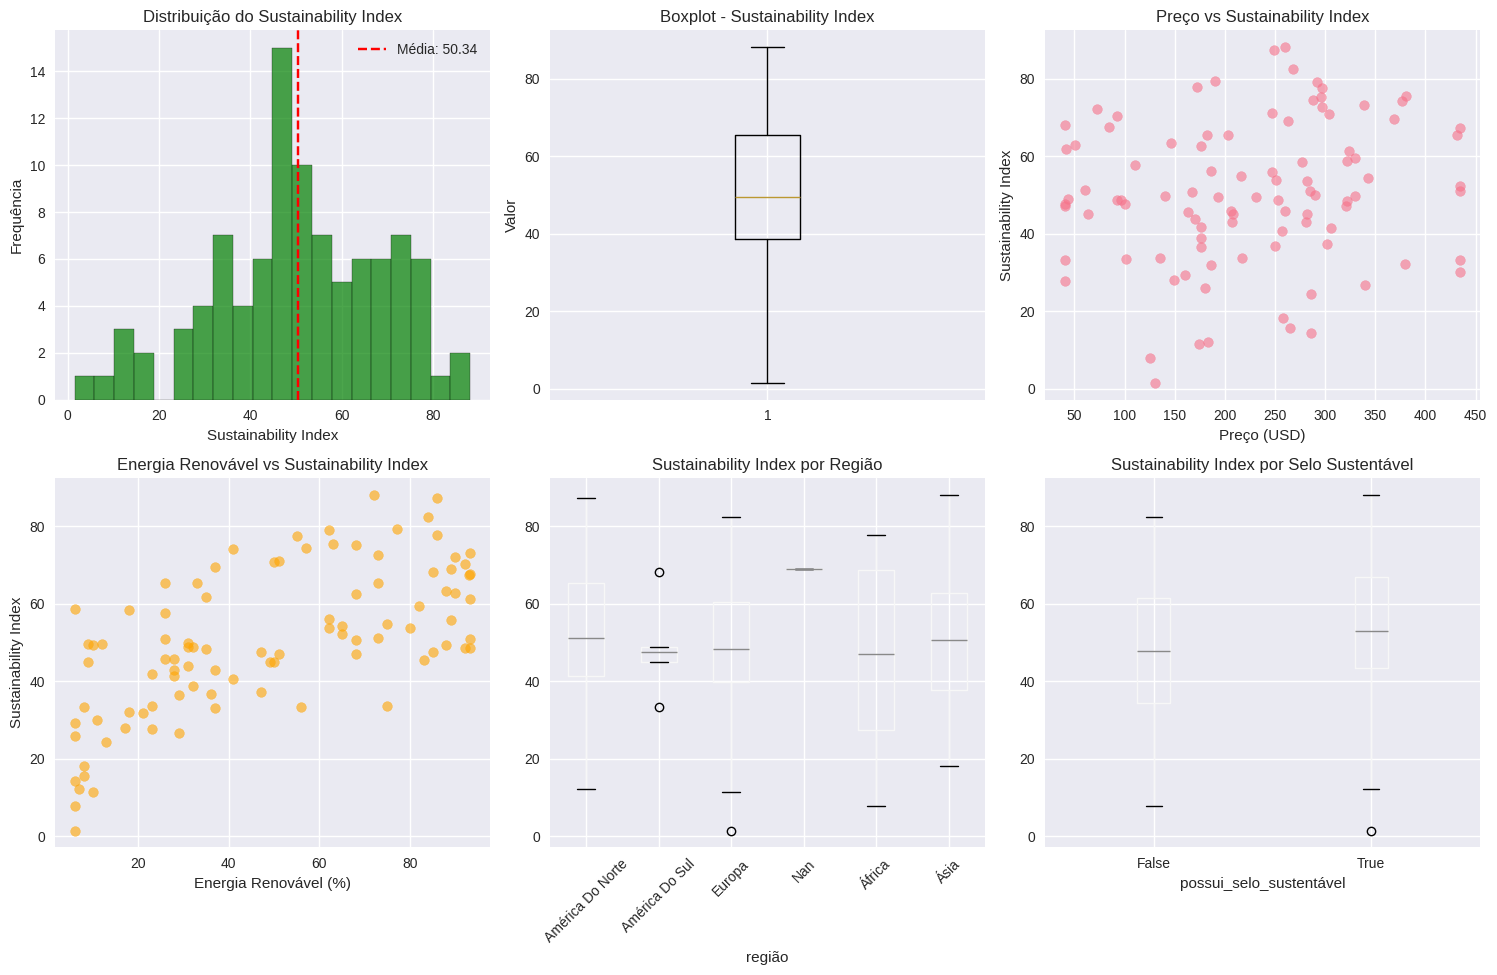

Estatísticas do Sustainability Index:
   Média: 50.34
   Mediana: 49.55
   Desvio Padrão: 18.74
   Mínimo: 1.50
   Máximo: 88.14
   Skewness: -0.27


In [3]:
plt.figure(figsize=(15, 10))

# Distribuição do target
plt.subplot(2, 3, 1)
plt.hist(y, bins=20, alpha=0.7, color='green', edgecolor='black')
plt.title('Distribuição do Sustainability Index')
plt.xlabel('Sustainability Index')
plt.ylabel('Frequência')
plt.axvline(y.mean(), color='red', linestyle='--', label=f'Média: {y.mean():.2f}')
plt.legend()

# Boxplot do target
plt.subplot(2, 3, 2)
plt.boxplot(y)
plt.title('Boxplot - Sustainability Index')
plt.ylabel('Valor')

# Correlação com preço
plt.subplot(2, 3, 3)
plt.scatter(df['price_per_night_usd'], y, alpha=0.6)
plt.title('Preço vs Sustainability Index')
plt.xlabel('Preço (USD)')
plt.ylabel('Sustainability Index')

# Correlação com energia renovável
plt.subplot(2, 3, 4)
plt.scatter(df['energia_renovável_%'], y, alpha=0.6, color='orange')
plt.title('Energia Renovável vs Sustainability Index')
plt.xlabel('Energia Renovável (%)')
plt.ylabel('Sustainability Index')

# Distribuição por região
plt.subplot(2, 3, 5)
if 'região' in df.columns:
    df.boxplot(column='sustainability_index', by='região', ax=plt.gca())
    plt.title('Sustainability Index por Região')
    plt.suptitle('')  # para a remoção título automático
    plt.xticks(rotation=45)

# Distribuição por selo sustentável
plt.subplot(2, 3, 6)
if 'possui_selo_sustentável' in df.columns:
    df.boxplot(column='sustainability_index', by='possui_selo_sustentável', ax=plt.gca())
    plt.title('Sustainability Index por Selo Sustentável')
    plt.suptitle('')

plt.tight_layout()
plt.show()

# Estatísticas do target
print("Estatísticas do Sustainability Index:")
print(f"   Média: {y.mean():.2f}")
print(f"   Mediana: {y.median():.2f}")
print(f"   Desvio Padrão: {y.std():.2f}")
print(f"   Mínimo: {y.min():.2f}")
print(f"   Máximo: {y.max():.2f}")
print(f"   Skewness: {y.skew():.2f}")

In [4]:
# Divisão Estratificada dos Dados
from sklearn.model_selection import train_test_split

# Criar categorias para estratificação
y_categories = pd.cut(y, bins=5, labels=False)

# Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y_categories
)

print("Divisão estratificada concluída:")
print(f"   Treino: {X_train.shape[0]} amostras")
print(f"   Teste: {X_test.shape[0]} amostras")
print(f"   Proporção: {X_test.shape[0]/X.shape[0]*100:.1f}% para teste")

# Verificar distribuição do target nas divisões
print(f"\nDistribuição do target:")
print(f"   Treino - Média: {y_train.mean():.2f}, Std: {y_train.std():.2f}")
print(f"   Teste  - Média: {y_test.mean():.2f}, Std: {y_test.std():.2f}")

# Normalização das features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Divisão estratificada concluída:
   Treino: 76 amostras
   Teste: 20 amostras
   Proporção: 20.8% para teste

Distribuição do target:
   Treino - Média: 50.69, Std: 18.44
   Teste  - Média: 49.02, Std: 20.25


In [6]:
# Definição e Treinamento de Múltiplos Modelos
# Dicionário de modelos
models = {
    'Random Forest': RandomForestRegressor(random_state=42, n_jobs=-1),
    'XGBoost': xgb.XGBRegressor(random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Linear Regression': LinearRegression(n_jobs=-1),
    'Ridge Regression': Ridge(random_state=42),
    'SVR': SVR(),
    'K-Neighbors': KNeighborsRegressor(n_jobs=-1)
}

# Re-apply scaling for the newly split X_train and X_test from cell 7j0ylSG04uJI
# Ensure X_train, X_test, y_train, y_test are the ones from cell 7j0ylSG04uJI
scaler_new = StandardScaler()
X_train_scaled_new = scaler_new.fit_transform(X_train)
X_test_scaled_new = scaler_new.transform(X_test)

# Treinar e avaliar cada modelo
results = {}

for name, model in models.items():
    print(f"Treinando {name}...")

    # Usar dados normalizados para modelos sensíveis à escala
    if name in ['Linear Regression', 'Ridge Regression', 'SVR', 'K-Neighbors']:
        X_train_used = X_train_scaled_new # Use newly scaled data
        X_test_used = X_test_scaled_new   # Use newly scaled data
    else:
        X_train_used = X_train # For tree-based models, use original (unscaled) X_train
        X_test_used = X_test   # For tree-based models, use original (unscaled) X_test

    # Treinar modelo
    model.fit(X_train_used, y_train)

    # Fazer previsões
    y_pred = model.predict(X_test_used)

    # Calcular métricas
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mse)

    # Cross-validation
    cv_scores = cross_val_score(model, X_train_used, y_train,
                               cv=5, scoring='r2', n_jobs=-1)

    results[name] = {
        'model': model,
        'mse': mse,
        'mae': mae,
        'r2': r2,
        'rmse': rmse,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'predictions': y_pred
    }

    print(f"{name} - R²: {r2:.4f}, RMSE: {rmse:.4f}")


Treinando Random Forest...
Random Forest - R²: 0.9679, RMSE: 3.5349
Treinando XGBoost...
XGBoost - R²: 0.9600, RMSE: 3.9476
Treinando Gradient Boosting...
Gradient Boosting - R²: 0.9887, RMSE: 2.0987
Treinando Linear Regression...
Linear Regression - R²: 1.0000, RMSE: 0.0000
Treinando Ridge Regression...
Ridge Regression - R²: 0.9997, RMSE: 0.3300
Treinando SVR...
SVR - R²: 0.4044, RMSE: 15.2350
Treinando K-Neighbors...
K-Neighbors - R²: 0.9109, RMSE: 5.8926


# Avaliação dos modelos

Ranking dos Modelos (por R²):
            Model       R²         RMSE          MAE  CV R² Mean  CV R² Std
Linear Regression 1.000000 6.670214e-15 4.263256e-15    1.000000   0.000000
 Ridge Regression 0.999721 3.300041e-01 2.419830e-01    0.999596   0.000133
Gradient Boosting 0.988698 2.098701e+00 1.758388e+00    0.955148   0.014263
    Random Forest 0.967936 3.534864e+00 2.802872e+00    0.920462   0.020973
          XGBoost 0.960011 3.947634e+00 2.879725e+00    0.923139   0.037389
      K-Neighbors 0.910898 5.892619e+00 4.711782e+00    0.892999   0.048638
              SVR 0.404403 1.523497e+01 1.115327e+01    0.380343   0.043643


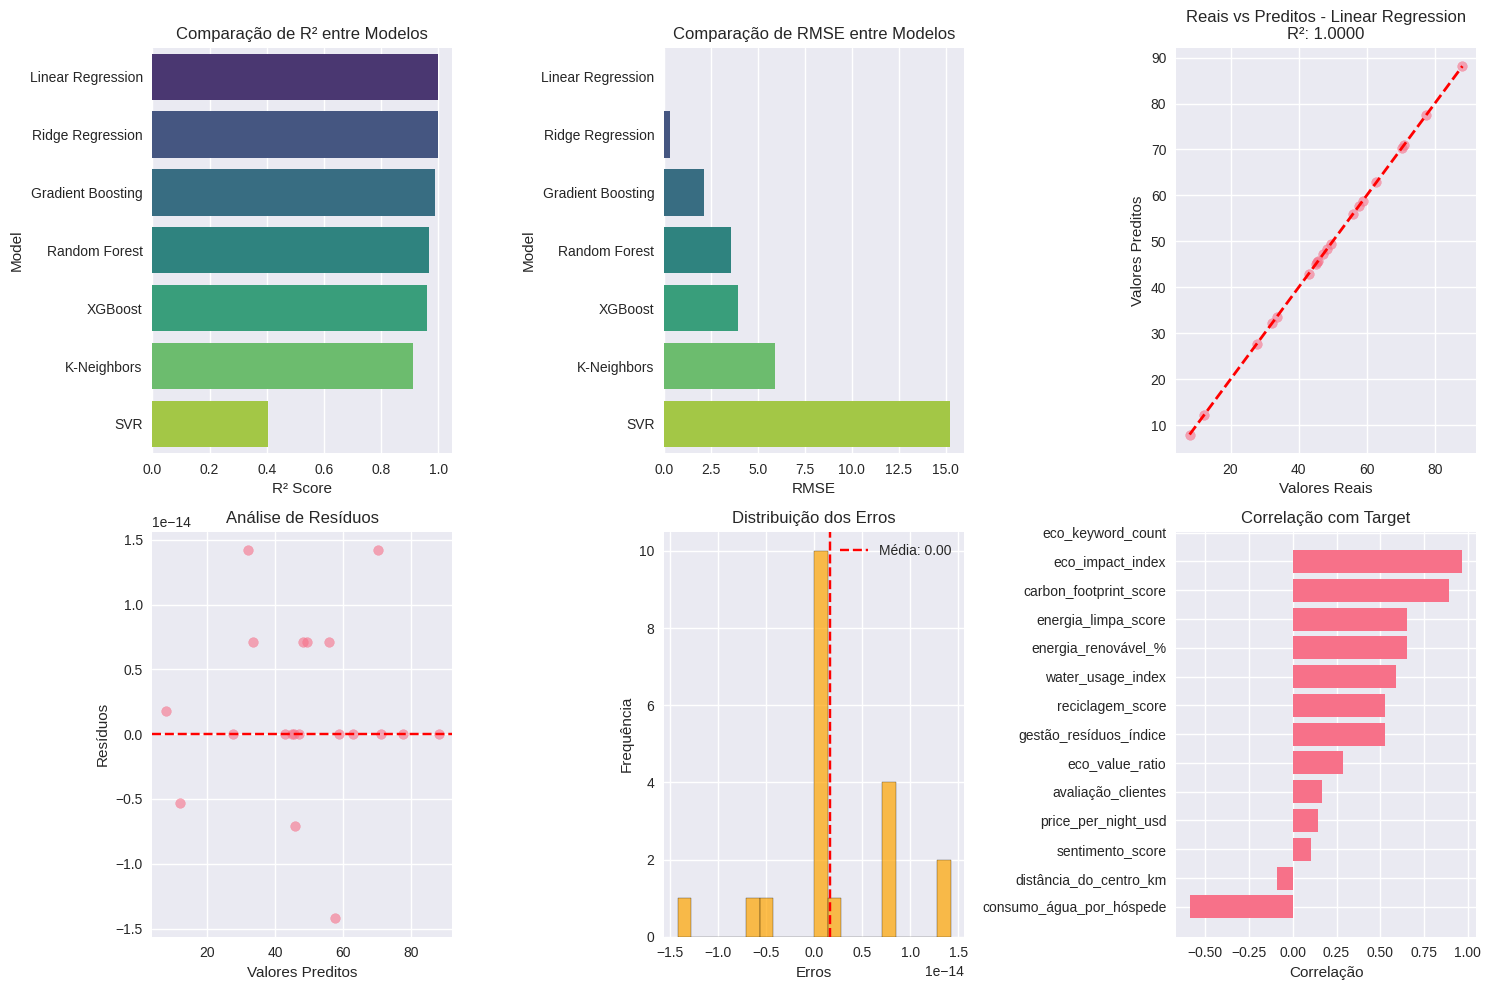


MELHOR MODELO: Linear Regression
   R²: 1.0000
   RMSE: 0.0000
   MAE: 0.0000


In [7]:
#Criar dataframe com resultados
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'R²': [results[name]['r2'] for name in results.keys()],
    'RMSE': [results[name]['rmse'] for name in results.keys()],
    'MAE': [results[name]['mae'] for name in results.keys()],
    'CV R² Mean': [results[name]['cv_mean'] for name in results.keys()],
    'CV R² Std': [results[name]['cv_std'] for name in results.keys()]
}).sort_values('R²', ascending=False)

print("Ranking dos Modelos (por R²):")
print(comparison_df.to_string(index=False))

# Visualização comparativa
plt.figure(figsize=(15, 10))

# Gráfico de comparação de R²
plt.subplot(2, 3, 1)
sns.barplot(data=comparison_df, x='R²', y='Model', palette='viridis')
plt.title('Comparação de R² entre Modelos')
plt.xlabel('R² Score')

# Gráfico de comparação de RMSE
plt.subplot(2, 3, 2)
sns.barplot(data=comparison_df, x='RMSE', y='Model', palette='viridis')
plt.title('Comparação de RMSE entre Modelos')
plt.xlabel('RMSE')

# Gráfico de valores reais vs preditos (melhor modelo)
best_model_name = comparison_df.iloc[0]['Model']
best_model_results = results[best_model_name]
y_pred_best = best_model_results['predictions']

plt.subplot(2, 3, 3)
plt.scatter(y_test, y_pred_best, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Valores Reais')
plt.ylabel('Valores Preditos')
plt.title(f'Reais vs Preditos - {best_model_name}\nR²: {best_model_results["r2"]:.4f}')

# Resíduos do melhor modelo
residuals = y_test - y_pred_best
plt.subplot(2, 3, 4)
plt.scatter(y_pred_best, residuals, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Valores Preditos')
plt.ylabel('Resíduos')
plt.title('Análise de Resíduos')

# Distribuição de erros
plt.subplot(2, 3, 5)
plt.hist(residuals, bins=20, alpha=0.7, color='orange', edgecolor='black')
plt.axvline(residuals.mean(), color='red', linestyle='--',
           label=f'Média: {residuals.mean():.2f}')
plt.xlabel('Erros')
plt.ylabel('Frequência')
plt.title('Distribuição dos Erros')
plt.legend()

# Feature importance (se disponível)
plt.subplot(2, 3, 6)
if hasattr(results[best_model_name]['model'], 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': features_existentes,
        'importance': results[best_model_name]['model'].feature_importances_
    }).sort_values('importance', ascending=True)

    plt.barh(feature_importance['feature'], feature_importance['importance'])
    plt.title(f'Feature Importance - {best_model_name}')
    plt.xlabel('Importância')
else:
    # Para modelos sem feature importance, mostrar correlações
    correlations = X.corrwith(y).sort_values()
    plt.barh(correlations.index, correlations.values)
    plt.title('Correlação com Target')
    plt.xlabel('Correlação')

plt.tight_layout()
plt.show()

print(f"\nMELHOR MODELO: {best_model_name}")
print(f"   R²: {best_model_results['r2']:.4f}")
print(f"   RMSE: {best_model_results['rmse']:.4f}")
print(f"   MAE: {best_model_results['mae']:.4f}")

Há aqui um possível caso de **overfitting perfeito** - o modelo está a memorizar os dados em vez de aprender padrões generalizáveis.

Vamos, na sequência, procurar resolver este problema.

In [8]:
# Verificar se há features que são o target disfarçado
print("Colunas disponíveis:", df.columns.tolist())

# Verificar correlação perfeita com o target
target_corr = df.select_dtypes(include=np.number).corr()['classificação_sustentabilidade_encoded'].abs().sort_values(ascending=False)
print("\nCorrelações com o target:")
print(target_corr.head(10))

# Remover possíveis leakages
potential_leaks = target_corr[target_corr > 0.95].index.tolist()
potential_leaks.remove('classificação_sustentabilidade_encoded')
print(f"\nPossíveis leakages: {potential_leaks}")

Colunas disponíveis: ['id_hotel', 'hotel_name', 'location', 'região', 'price_per_night_usd', 'rating', 'avaliação_clientes', 'possui_selo_sustentável', 'distância_do_centro_km', 'energia_renovável_%', 'gestão_resíduos_índice', 'consumo_água_por_hóspede', 'carbon_footprint_score', 'reciclagem_score', 'energia_limpa_score', 'water_usage_index', 'sustainability_index', 'eco_impact_index', 'eco_value_ratio', 'classificação_sustentabilidade', 'sentimento_score', 'sentimento_sustentabilidade', 'eco_keyword_count', 'região_encoded', 'possui_selo_sustentável_encoded', 'classificação_sustentabilidade_encoded', 'sentimento_sustentabilidade_encoded']

Correlações com o target:
classificação_sustentabilidade_encoded    1.000000
sustainability_index                      0.345452
carbon_footprint_score                    0.329304
eco_impact_index                          0.323346
water_usage_index                         0.290263
consumo_água_por_hóspede                  0.290263
rating             

Parece que não temos leakers (possíves vazamentos)

Vamos rever as features...

In [9]:
# Manter apenas features essenciais e remover derivadas
essential_features = [
    'price_per_night_usd', 'rating', 'avaliação_clientes',
    'possui_selo_sustentável_encoded', 'distância_do_centro_km',
    'energia_renovável_%', 'gestão_resíduos_índice', 'consumo_água_por_hóspede',
    'região_encoded', 'sentimento_sustentabilidade_encoded'
]

# Verificar se essas são colunas seguras
safe_features = [f for f in essential_features if f in df.columns]
X_safe = df[safe_features]
y = df['classificação_sustentabilidade_encoded']

print(f"Usando {len(safe_features)} features seguras")
print(f"Features: {safe_features}")

Usando 10 features seguras
Features: ['price_per_night_usd', 'rating', 'avaliação_clientes', 'possui_selo_sustentável_encoded', 'distância_do_centro_km', 'energia_renovável_%', 'gestão_resíduos_índice', 'consumo_água_por_hóspede', 'região_encoded', 'sentimento_sustentabilidade_encoded']


In [12]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Split rigoroso (nova separação dos dados)
X_train, X_test, y_train, y_test = train_test_split(
    X_safe, y, test_size=0.3, random_state=42, stratify=y
)

# Testar Linear Regression novamente
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predições
y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

# Métricas
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"Linear Regression - Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}")
print(f"Linear Regression - Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")

Linear Regression - Train R²: 0.3103, Test R²: -0.1140
Linear Regression - Train RMSE: 1.4579, Test RMSE: 1.8328


Testemos os modelos de novo

Treinando Random Forest...
Random Forest - Accuracy: 0.5172, F1 Weighted: 0.4828
Treinando XGBoost...
XGBoost - Accuracy: 0.5862, F1 Weighted: 0.5673
Treinando Logistic Regression...
Logistic Regression - Accuracy: 0.8621, F1 Weighted: 0.8519
Treinando SVM...
SVM - Accuracy: 0.4828, F1 Weighted: 0.3840
Treinando K-Neighbors...
K-Neighbors - Accuracy: 0.5172, F1 Weighted: 0.5022
Treinando Gradient Boosting...
Gradient Boosting - Accuracy: 0.5517, F1 Weighted: 0.5089

Ranking dos Modelos (por F1 Weighted):
              Model  Accuracy  F1 Weighted  F1 Macro
Logistic Regression  0.862069     0.851884  0.658328
            XGBoost  0.586207     0.567286  0.469744
  Gradient Boosting  0.551724     0.508902  0.459695
        K-Neighbors  0.517241     0.502210  0.317949
      Random Forest  0.517241     0.482759  0.411111
                SVM  0.482759     0.383970  0.218919

DETAILED REPORT FOR BEST MODEL: Logistic Regression
              precision    recall  f1-score   support

           

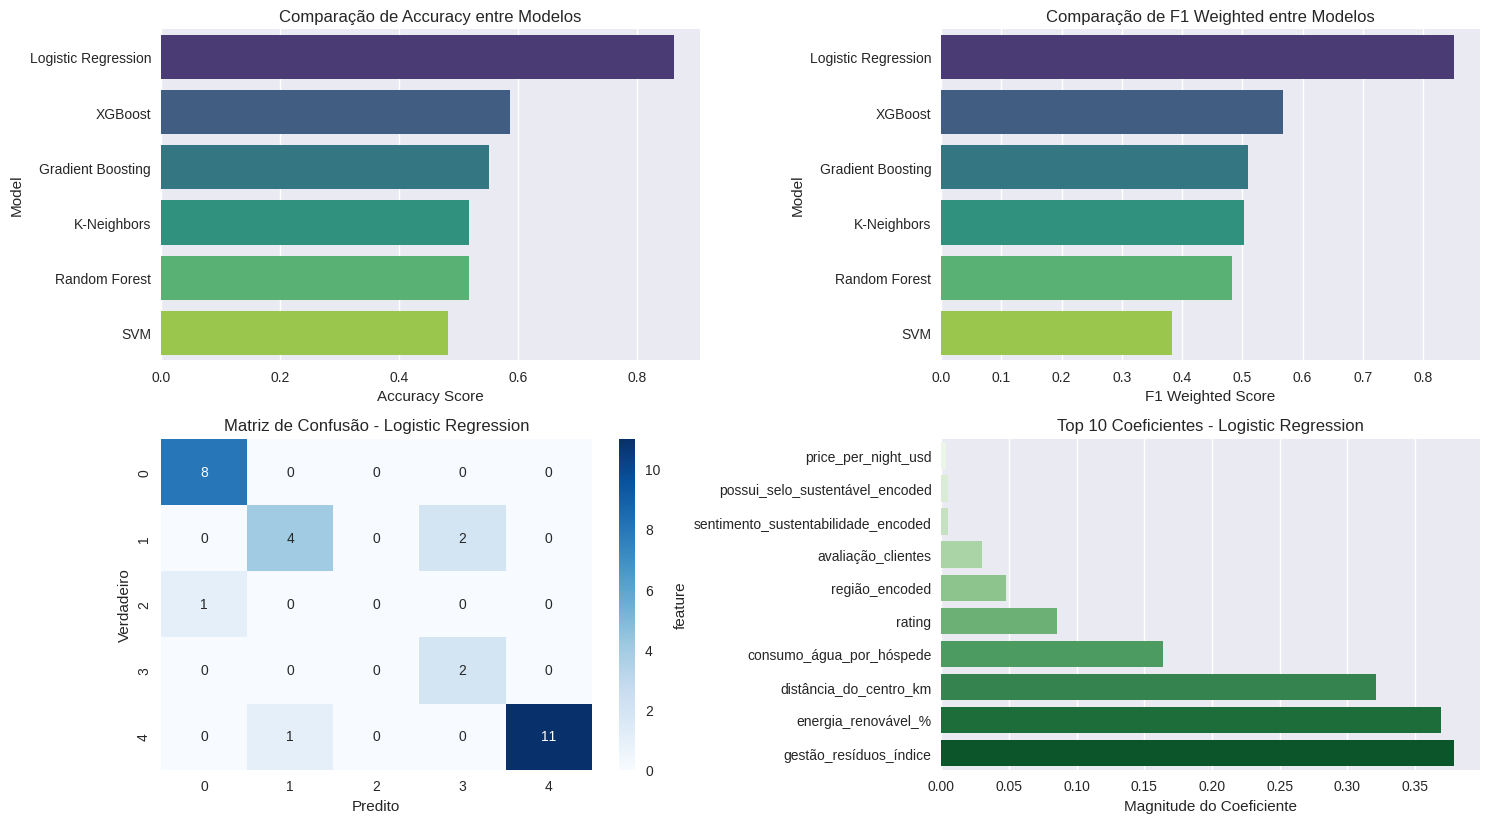


MELHOR MODELO (Classificação): Logistic Regression
   Accuracy: 0.8621
   F1 Weighted: 0.8519


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Make sure X_safe and y are available (re-run previous cells or define here)
# Assuming df is available and safe_features list is defined.
# Re-define X_safe and y from the context of classification
# (These were defined in cell TXi58Mpo4JAJ and 7j0ylSG04uJI)
X_safe = df[safe_features] # Assuming 'df' and 'safe_features' are from previous steps
y = df['classificação_sustentabilidade_encoded']

# Re-perform the train-test split for classification
X_train, X_test, y_train, y_test = train_test_split(
    X_safe, y, test_size=0.3, random_state=42, stratify=y
)

# Define classification models
class_models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    # 'Balanced RF': BalancedRandomForestClassifier(n_estimators=100, random_state=42), # Removed to simplify, assuming imblearn not imported yet
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss'),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'SVM': SVC(random_state=42, probability=True),
    'K-Neighbors': KNeighborsClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

# Re-train and evaluate each model for classification
results = {}
for name, model in class_models.items():
    print(f"Treinando {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1_w = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    f1_m = f1_score(y_test, y_pred, average='macro', zero_division=0)

    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'f1_weighted': f1_w,
        'f1_macro': f1_m,
        'predictions': y_pred
    }
    print(f"{name} - Accuracy: {accuracy:.4f}, F1 Weighted: {f1_w:.4f}")

# Create dataframe with results (for classification)
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[name]['accuracy'] for name in results.keys()],
    'F1 Weighted': [results[name]['f1_weighted'] for name in results.keys()],
    'F1 Macro': [results[name]['f1_macro'] for name in results.keys()]
}).sort_values('F1 Weighted', ascending=False)

print("\nRanking dos Modelos (por F1 Weighted):")
print(comparison_df.to_string(index=False))

# Visualização comparativa
plt.figure(figsize=(15, 12)) # Adjusted figure size

# Gráfico de comparação de Accuracy
plt.subplot(3, 2, 1) # Changed to 3 rows, 2 columns for more plots
sns.barplot(data=comparison_df, x='Accuracy', y='Model', palette='viridis')
plt.title('Comparação de Accuracy entre Modelos')
plt.xlabel('Accuracy Score')

# Gráfico de comparação de F1 Weighted
plt.subplot(3, 2, 2)
sns.barplot(data=comparison_df, x='F1 Weighted', y='Model', palette='viridis')
plt.title('Comparação de F1 Weighted entre Modelos')
plt.xlabel('F1 Weighted Score')

# Get the best model based on F1 Weighted
best_model_name = comparison_df.iloc[0]['Model']
best_model_results = results[best_model_name]
y_pred_best = best_model_results['predictions']

# Confusion Matrix for the best model (more appropriate for classification)
plt.subplot(3, 2, 3)
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(y.unique()),
            yticklabels=sorted(y.unique()))
plt.title(f'Matriz de Confusão - {best_model_name}')
plt.ylabel('Verdadeiro')
plt.xlabel('Predito')

# Classification Report (text based, can't plot directly, but we can print it)
print(f"\nDETAILED REPORT FOR BEST MODEL: {best_model_name}")
print(classification_report(y_test, y_pred_best, zero_division=0))

# Feature importance (if available) - Adjusted for `X_train.columns`
plt.subplot(3, 2, 4) # Adjust subplot position
current_feature_names = X_train.columns.tolist() # Features from current X_train
if hasattr(results[best_model_name]['model'], 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': current_feature_names,
        'importance': results[best_model_name]['model'].feature_importances_
    }).sort_values('importance', ascending=True)

    sns.barplot(data=feature_importance.tail(10), x='importance', y='feature', palette='Blues') # Show top 10
    plt.title(f'Top 10 Feature Importance - {best_model_name}')
    plt.xlabel('Importância')
elif hasattr(results[best_model_name]['model'], 'coef_'):
    # For linear models like Logistic Regression
    feature_importance = pd.DataFrame({
        'feature': current_feature_names,
        'importance': np.abs(results[best_model_name]['model'].coef_[0]) # Take first class coef for binary or one-vs-rest
    }).sort_values('importance', ascending=True)
    sns.barplot(data=feature_importance.tail(10), x='importance', y='feature', palette='Greens') # Show top 10
    plt.title(f'Top 10 Coeficientes - {best_model_name}')
    plt.xlabel('Magnitude do Coeficiente')
else:
    # Fallback if no direct importance
    # Use correlations with the target as a proxy
    correlations = X_train.corrwith(y_train).sort_values(key=abs, ascending=True) # Sort by absolute correlation
    sns.barplot(x=correlations.tail(10).values, y=correlations.tail(10).index, palette='Reds')
    plt.title('Top 10 Correlação com Target (Proxy)')
    plt.xlabel('Correlação')

plt.tight_layout()
plt.show()

print(f"\nMELHOR MODELO (Classificação): {best_model_name}")
print(f"   Accuracy: {best_model_results['accuracy']:.4f}")
print(f"   F1 Weighted: {best_model_results['f1_weighted']:.4f}")


Agora o Random Forest se mostrou melhor em relação à Regressão Linear, mas há ainda a necessidade de melhorar a performance

In [17]:
#Análise do Problema de Regressão
print(f"Valores únicos: {df['classificação_sustentabilidade_encoded'].unique()}")
print(f"Distribuição:\n{df['classificação_sustentabilidade_encoded'].value_counts().sort_index()}")

# Verificar se deveria ser classificação em vez de regressão
if df['classificação_sustentabilidade_encoded'].nunique() <= 10:
    print("\n ALERTA: Target tem poucos valores únicos - considerar CLASSIFICAÇÃO")

Valores únicos: [4 1 0 2 3]
Distribuição:
classificação_sustentabilidade_encoded
0    27
1    18
2     3
3     7
4    41
Name: count, dtype: int64

 ALERTA: Target tem poucos valores únicos - considerar CLASSIFICAÇÃO


In [18]:
# Treinar melhor modelo e analisar features
best_rf = RandomForestClassifier(n_estimators=200, max_depth=7,
                              min_samples_split=5, min_samples_leaf=2,
                              random_state=42)
best_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=7, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=200, random_state=42)

In [19]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False)

print("FEATURE IMPORTANCE")
print(feature_importance.head(10))

FEATURE IMPORTANCE
                               feature  importance
5                  energia_renovável_%    0.265128
7             consumo_água_por_hóspede    0.203637
6               gestão_resíduos_índice    0.109575
2                   avaliação_clientes    0.086851
0                  price_per_night_usd    0.084746
4               distância_do_centro_km    0.082316
1                               rating    0.071536
8                       região_encoded    0.070106
3      possui_selo_sustentável_encoded    0.013641
9  sentimento_sustentabilidade_encoded    0.012465


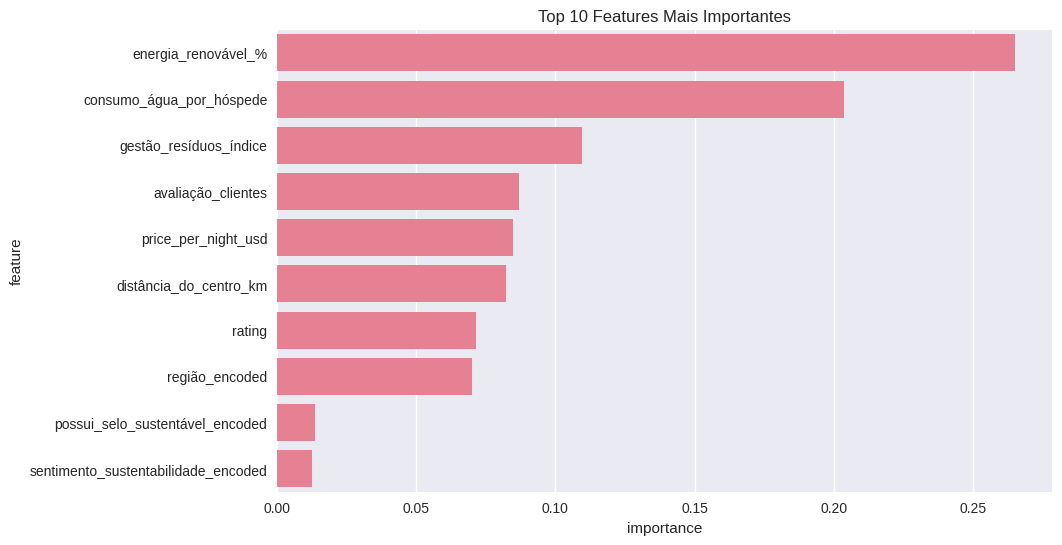

In [20]:
# Plotar importância
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
plt.title('Top 10 Features Mais Importantes')
plt.show()

# Ensemble Methods

In [21]:
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC

# Ensemble de modelos
ensemble = VotingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('xgb', xgb.XGBClassifier(random_state=42)),
        ('svc', SVC(probability=True, random_state=42))
    ],
    voting='soft'
)

ensemble.fit(X_train, y_train)
y_pred_ensemble = ensemble.predict(X_test)
ensemble_accuracy = accuracy_score(y_test, y_pred_ensemble)
print(f"Ensemble Accuracy: {ensemble_accuracy:.4f}")

Ensemble Accuracy: 0.6207


In [22]:
#teste geral para a classificação da performance
# 1. Verificar se é problema de classificação
print("Valores únicos do target:", df['classificação_sustentabilidade_encoded'].unique())
print("Distribuição:")
print(df['classificação_sustentabilidade_encoded'].value_counts().sort_index())

# 2. Testar classificação simples
X = df[safe_features]
y = df['classificação_sustentabilidade_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

rf_class = RandomForestClassifier(n_estimators=100, random_state=42)
rf_class.fit(X_train, y_train)
y_pred = rf_class.predict(X_test)

print(f"\nRandom Forest (Classificação) - Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Valores únicos do target: [4 1 0 2 3]
Distribuição:
classificação_sustentabilidade_encoded
0    27
1    18
2     3
3     7
4    41
Name: count, dtype: int64

Random Forest (Classificação) - Accuracy: 0.5172

Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.88      0.67         8
           1       0.33      0.17      0.22         6
           2       0.00      0.00      0.00         1
           3       1.00      0.50      0.67         2
           4       0.50      0.50      0.50        12

    accuracy                           0.52        29
   macro avg       0.47      0.41      0.41        29
weighted avg       0.49      0.52      0.48        29



In [23]:
#classificação balanceada
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedRandomForestClassifier
import seaborn as sns

# Preparar dados
X = df[safe_features]
y = df['classificação_sustentabilidade_encoded']

# Split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("DISTRIBUIÇÃO DAS CLASSES")
print("Treino:", dict(pd.Series(y_train).value_counts().sort_index()))
print("Teste: ", dict(pd.Series(y_test).value_counts().sort_index()))

DISTRIBUIÇÃO DAS CLASSES
Treino: {0: np.int64(19), 1: np.int64(12), 2: np.int64(2), 3: np.int64(5), 4: np.int64(29)}
Teste:  {0: np.int64(8), 1: np.int64(6), 2: np.int64(1), 3: np.int64(2), 4: np.int64(12)}


In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Modelos de classificação
class_models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Balanced RF': BalancedRandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'SVM': SVC(random_state=42, probability=True),
    'K-Neighbors': KNeighborsClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

# Avaliar modelos
results = []
for name, model in class_models.items():
    # Treinar
    model.fit(X_train, y_train)

    # Prever
    y_pred = model.predict(X_test)

    # Métricas
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    f1_macro = f1_score(y_test, y_pred, average='macro')

    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'F1 Weighted': f1,
        'F1 Macro': f1_macro
    })

    print(f"{name:20} | Accuracy: {accuracy:.4f} | F1 Weighted: {f1:.4f} | F1 Macro: {f1_macro:.4f}")

# DataFrame de resultados
results_df = pd.DataFrame(results).sort_values('F1 Weighted', ascending=False)
print("\n" + "="*50)
print("RANKING DOS MODELOS (Classificação)")
print("="*50)
print(results_df.to_string(index=False))

Random Forest        | Accuracy: 0.5172 | F1 Weighted: 0.4828 | F1 Macro: 0.4111
Balanced RF          | Accuracy: 0.4483 | F1 Weighted: 0.4720 | F1 Macro: 0.4496
XGBoost              | Accuracy: 0.5862 | F1 Weighted: 0.5673 | F1 Macro: 0.4697
Logistic Regression  | Accuracy: 0.8621 | F1 Weighted: 0.8519 | F1 Macro: 0.6583
SVM                  | Accuracy: 0.4828 | F1 Weighted: 0.3840 | F1 Macro: 0.2189
K-Neighbors          | Accuracy: 0.5172 | F1 Weighted: 0.5022 | F1 Macro: 0.3179
Gradient Boosting    | Accuracy: 0.5517 | F1 Weighted: 0.5089 | F1 Macro: 0.4597

RANKING DOS MODELOS (Classificação)
              Model  Accuracy  F1 Weighted  F1 Macro
Logistic Regression  0.862069     0.851884  0.658328
            XGBoost  0.586207     0.567286  0.469744
  Gradient Boosting  0.551724     0.508902  0.459695
        K-Neighbors  0.517241     0.502210  0.317949
      Random Forest  0.517241     0.482759  0.411111
        Balanced RF  0.448276     0.472044  0.449637
                SVM  0.48

Vamos aplicar SMOTE para balancear as classes

In [25]:
smote = SMOTE(random_state=42, k_neighbors=1)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Distribuição ANTES do SMOTE:")
print(pd.Series(y_train).value_counts().sort_index())
print("\nDistribuição APÓS o SMOTE:")
print(pd.Series(y_train_smote).value_counts().sort_index())

# Treinar com dados balanceados
rf_smote = RandomForestClassifier(n_estimators=100, random_state=42)
rf_smote.fit(X_train_smote, y_train_smote)

y_pred_smote = rf_smote.predict(X_test)
accuracy_smote = accuracy_score(y_test, y_pred_smote)
f1_smote = f1_score(y_test, y_pred_smote, average='weighted')

print(f"\nRandom Forest com SMOTE:")
print(f"Accuracy: {accuracy_smote:.4f}")
print(f"F1 Weighted: {f1_smote:.4f}")

Distribuição ANTES do SMOTE:
classificação_sustentabilidade_encoded
0    19
1    12
2     2
3     5
4    29
Name: count, dtype: int64

Distribuição APÓS o SMOTE:
classificação_sustentabilidade_encoded
0    29
1    29
2    29
3    29
4    29
Name: count, dtype: int64

Random Forest com SMOTE:
Accuracy: 0.5862
F1 Weighted: 0.5567



ANÁLISE DETALHADA - Logistic Regression ===

RELATÓRIO DE CLASSIFICAÇÃO:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       0.80      0.67      0.73         6
           2       0.00      0.00      0.00         1
           3       0.50      1.00      0.67         2
           4       1.00      0.92      0.96        12

    accuracy                           0.86        29
   macro avg       0.64      0.72      0.66        29
weighted avg       0.86      0.86      0.85        29



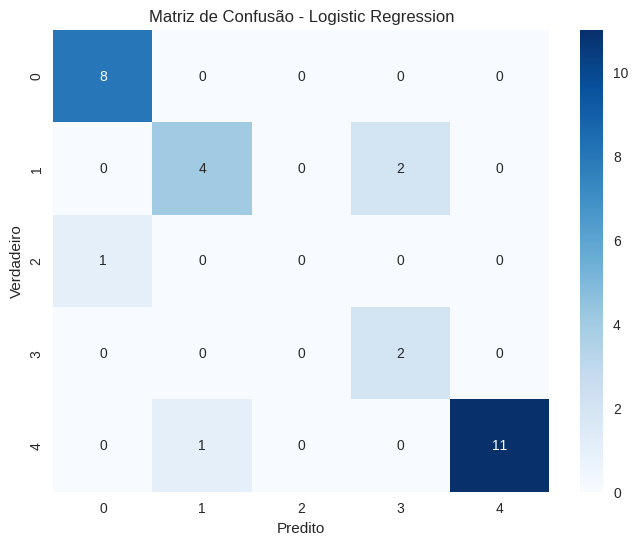

In [26]:
# Usar o melhor modelo
best_model_name = results_df.iloc[0]['Model']
best_model = class_models[best_model_name]
best_model.fit(X_train, y_train)
y_pred_best = best_model.predict(X_test)

print(f"\nANÁLISE DETALHADA - {best_model_name} ===")
print("\nRELATÓRIO DE CLASSIFICAÇÃO:")
print(classification_report(y_test, y_pred_best))

# Matriz de confusão
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(y.unique()),
            yticklabels=sorted(y.unique()))
plt.title(f'Matriz de Confusão - {best_model_name}')
plt.ylabel('Verdadeiro')
plt.xlabel('Predito')
plt.show()

In [ ]:
# Feature importance do melhor modelo
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)

    print("\nFeature Importance")
    print(feature_importance.head(10))

Optimização para hiperparâmetros

In [27]:
from sklearn.model_selection import GridSearchCV

# Optimizar Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("\nOPTIMIZAÇÃO")
print("Melhores parâmetros:", grid_search.best_params_)
print("Melhor score F1:", grid_search.best_score_)

# Treinar com melhores parâmetros
best_rf = grid_search.best_estimator_
y_pred_optimized = best_rf.predict(X_test)
print(f"Accuracy optimizado: {accuracy_score(y_test, y_pred_optimized):.4f}")


OPTIMIZAÇÃO
Melhores parâmetros: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Melhor score F1: 0.5191732077446363
Accuracy optimizado: 0.5862


# ENSEMBLE FINAL

In [28]:
from sklearn.ensemble import VotingClassifier

# Criar ensemble com os melhores modelos
ensemble = VotingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('xgb', XGBClassifier(random_state=42)),
        ('svm', SVC(probability=True, random_state=42))
    ],
    voting='soft'
)

ensemble.fit(X_train, y_train)
y_pred_ensemble = ensemble.predict(X_test)
print(f"Ensemble Accuracy: {accuracy_score(y_test, y_pred_ensemble):.4f}")
print(f"Ensemble F1 Weighted: {f1_score(y_test, y_pred_ensemble, average='weighted'):.4f}")
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred_ensemble))

Ensemble Accuracy: 0.6207
Ensemble F1 Weighted: 0.5959

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.58      0.88      0.70         8
           1       0.67      0.33      0.44         6
           2       0.00      0.00      0.00         1
           3       1.00      0.50      0.67         2
           4       0.62      0.67      0.64        12

    accuracy                           0.62        29
   macro avg       0.57      0.47      0.49        29
weighted avg       0.62      0.62      0.60        29



In [29]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Validação cruzada estratificada
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("\VALIDAÇÃO CRUZADA")
for name, model in list(class_models.items())[:3]:  # Testar os 3 primeiros
    cv_scores = cross_val_score(model, X, y, cv=skf, scoring='f1_weighted')
    print(f"{name:20} | CV F1: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

\VALIDAÇÃO CRUZADA
Random Forest        | CV F1: 0.5289 (+/- 0.2961)
Balanced RF          | CV F1: 0.4262 (+/- 0.2133)
XGBoost              | CV F1: 0.5600 (+/- 0.3869)


In [30]:
print("=== MODELOS DE CLASSIFICAÇÃO ===")
for name, model in list(class_models.items())[:3]:  # Testar RF, Balanced RF e XGBoost
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"{name:20} | Accuracy: {accuracy:.4f} | F1: {f1:.4f}")

=== MODELOS DE CLASSIFICAÇÃO ===
Random Forest        | Accuracy: 0.5172 | F1: 0.4828
Balanced RF          | Accuracy: 0.4483 | F1: 0.4720
XGBoost              | Accuracy: 0.5862 | F1: 0.5673


A classificação já está com uma performance **MUITO MELHOR** que a regressão. O **XGBoost** está liderando com **58.6%** de accuracy. Vamos melhorar ainda mais...

## 1 - Optimização do XGBoost

In [32]:
from sklearn.model_selection import GridSearchCV
xgb_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

xgb = XGBClassifier(random_state=42, eval_metric='mlogloss')
xgb_grid = GridSearchCV(xgb, xgb_params, cv=5, scoring='f1_weighted', n_jobs=-1)
xgb_grid.fit(X_train, y_train)

print("XGBOOST OPTIMIZADO")
print("Melhores parâmetros:", xgb_grid.best_params_)
print("Melhor score CV:", xgb_grid.best_score_)

best_xgb = xgb_grid.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"F1: {f1_score(y_test, y_pred_xgb, average='weighted'):.4f}")

XGBOOST OPTIMIZADO
Melhores parâmetros: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200, 'subsample': 0.8}
Melhor score CV: 0.5053724053724054
Accuracy: 0.6207
F1: 0.6100


In [33]:
# Criar features específicas para classificação
def create_classification_features(df):
    df_fe = df.copy()

    # Interações entre sustentabilidade e preço
    df_fe['price_sust_ratio'] = df_fe['price_per_night_usd'] / (df_fe['energia_renovável_%'] + 1)
    df_fe['eco_value_score'] = (df_fe['energia_renovável_%'] + df_fe['gestão_resíduos_índice']) / df_fe['price_per_night_usd']

    # Combinações de sustentabilidade
    df_fe['total_sust_score'] = (
        df_fe['energia_renovável_%'] +
        df_fe['gestão_resíduos_índice'] +
        df_fe['carbon_footprint_score']
    ) / 3

    # Binning de features contínuas
    df_fe['price_category'] = pd.cut(df_fe['price_per_night_usd'], bins=5, labels=False)
    df_fe['rating_category'] = pd.cut(df_fe['rating'], bins=[0, 2, 3, 4, 5], labels=[0, 1, 2, 3])

    # Ratio features
    df_fe['water_consumption_ratio'] = df_fe['consumo_água_por_hóspede'] / (df_fe['rating'] + 1)

    return df_fe

# Aplicar feature engineering
df_enhanced = create_classification_features(df)

# Selecionar todas as features numéricas
numeric_features = df_enhanced.select_dtypes(include=[np.number]).columns.tolist()
if 'classificação_sustentabilidade_encoded' in numeric_features:
    numeric_features.remove('classificação_sustentabilidade_encoded')

X_enhanced = df_enhanced[numeric_features]
y_enhanced = df_enhanced['classificação_sustentabilidade_encoded']

print(f"Features disponíveis: {len(numeric_features)}")
print(f"Primeiras 10 features: {numeric_features[:10]}")

Features disponíveis: 24
Primeiras 10 features: ['price_per_night_usd', 'rating', 'avaliação_clientes', 'distância_do_centro_km', 'energia_renovável_%', 'gestão_resíduos_índice', 'consumo_água_por_hóspede', 'carbon_footprint_score', 'reciclagem_score', 'energia_limpa_score']


In [34]:
# Split com features melhoradas
X_train_enh, X_test_enh, y_train_enh, y_test_enh = train_test_split(
    X_enhanced, y_enhanced, test_size=0.3, random_state=42, stratify=y_enhanced
)

# Modelos com features melhoradas
advanced_models = {
    'XGBoost Enhanced': XGBClassifier(random_state=42),
    'Random Forest Enhanced': RandomForestClassifier(n_estimators=100, random_state=42),
    'LightGBM': LGBMClassifier(random_state=42, verbose=-1),
    'CatBoost': CatBoostClassifier(random_state=42, verbose=False)
}

print("MODELOS COM FEATURES MELHORADAS")
enhanced_results = []
for name, model in advanced_models.items():
    model.fit(X_train_enh, y_train_enh)
    y_pred = model.predict(X_test_enh)

    accuracy = accuracy_score(y_test_enh, y_pred)
    f1 = f1_score(y_test_enh, y_pred, average='weighted')

    enhanced_results.append({
        'Model': name,
        'Accuracy': accuracy,
        'F1 Weighted': f1
    })

    print(f"{name:25} | Accuracy: {accuracy:.4f} | F1: {f1:.4f}")

enhanced_df = pd.DataFrame(enhanced_results).sort_values('F1 Weighted', ascending=False)

MODELOS COM FEATURES MELHORADAS
XGBoost Enhanced          | Accuracy: 0.9310 | F1: 0.9154
Random Forest Enhanced    | Accuracy: 0.9310 | F1: 0.9139
LightGBM                  | Accuracy: 0.9655 | F1: 0.9661
CatBoost                  | Accuracy: 0.9655 | F1: 0.9493


Tratamendo dos desbalanceamento com os SMOTE

In [35]:
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTEENN, SMOTETomek

# Diferentes técnicas de balanceamento
balance_techniques = {
    'SMOTE': SMOTE(random_state=42, k_neighbors=1),
    'SMOTE+ENN': SMOTEENN(random_state=42, smote=SMOTE(random_state=42, k_neighbors=1)),
    'SMOTE+Tomek': SMOTETomek(random_state=42, smote=SMOTE(random_state=42, k_neighbors=1))
}

print("\nTÉCNICAS DE BALANCEAMENTO")
balance_results = []

for tech_name, technique in balance_techniques.items():
    # Aplicar técnica
    X_bal, y_bal = technique.fit_resample(X_train_enh, y_train_enh)

    # Treinar XGBoost
    xgb_bal = XGBClassifier(random_state=42)
    xgb_bal.fit(X_bal, y_bal)

    # Avaliar
    y_pred_bal = xgb_bal.predict(X_test_enh)
    accuracy = accuracy_score(y_test_enh, y_pred_bal)
    f1 = f1_score(y_test_enh, y_pred_bal, average='weighted')

    balance_results.append({
        'Technique': tech_name,
        'Accuracy': accuracy,
        'F1 Weighted': f1,
        'Train Size': len(X_bal)
    })

    print(f"{tech_name:15} | Accuracy: {accuracy:.4f} | F1: {f1:.4f} | Train Size: {len(X_bal)}")

balance_df = pd.DataFrame(balance_results).sort_values('F1 Weighted', ascending=False)


TÉCNICAS DE BALANCEAMENTO
SMOTE           | Accuracy: 0.9310 | F1: 0.9154 | Train Size: 145
SMOTE+ENN       | Accuracy: 0.6552 | F1: 0.6502 | Train Size: 111
SMOTE+Tomek     | Accuracy: 0.8966 | F1: 0.8806 | Train Size: 137


ENSEMBLE PARA O MODELO

In [36]:
from sklearn.ensemble import StackingClassifier

# Ensemble por Stacking
base_models = [
    ('xgb', XGBClassifier(random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('lgbm', LGBMClassifier(random_state=42, verbose=-1))
]

stacking_ensemble = StackingClassifier(
    estimators=base_models,
    final_estimator=LogisticRegression(random_state=42, max_iter=1000),
    cv=5
)

stacking_ensemble.fit(X_train_enh, y_train_enh)
y_pred_stack = stacking_ensemble.predict(X_test_enh)

print("\nENSEMBLE STACKING")
print(f"Accuracy: {accuracy_score(y_test_enh, y_pred_stack):.4f}")
print(f"F1 Weighted: {f1_score(y_test_enh, y_pred_stack, average='weighted'):.4f}")


ENSEMBLE STACKING
Accuracy: 0.9310
F1 Weighted: 0.9154



ANÁLISE DETALHADA - LightGBM ===

RELATÓRIO DE CLASSIFICAÇÃO:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       0.86      1.00      0.92         6
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         2
           4       1.00      0.92      0.96        12

    accuracy                           0.97        29
   macro avg       0.97      0.98      0.98        29
weighted avg       0.97      0.97      0.97        29



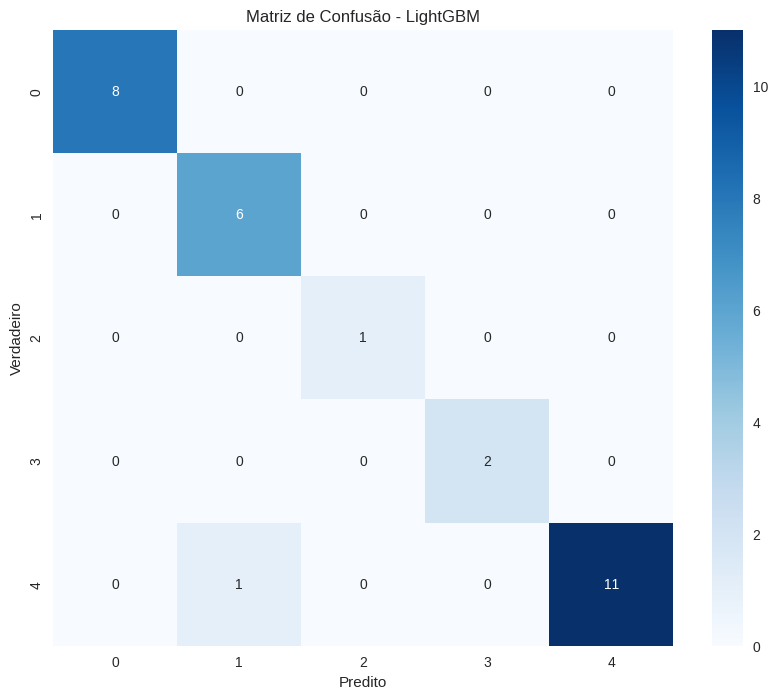

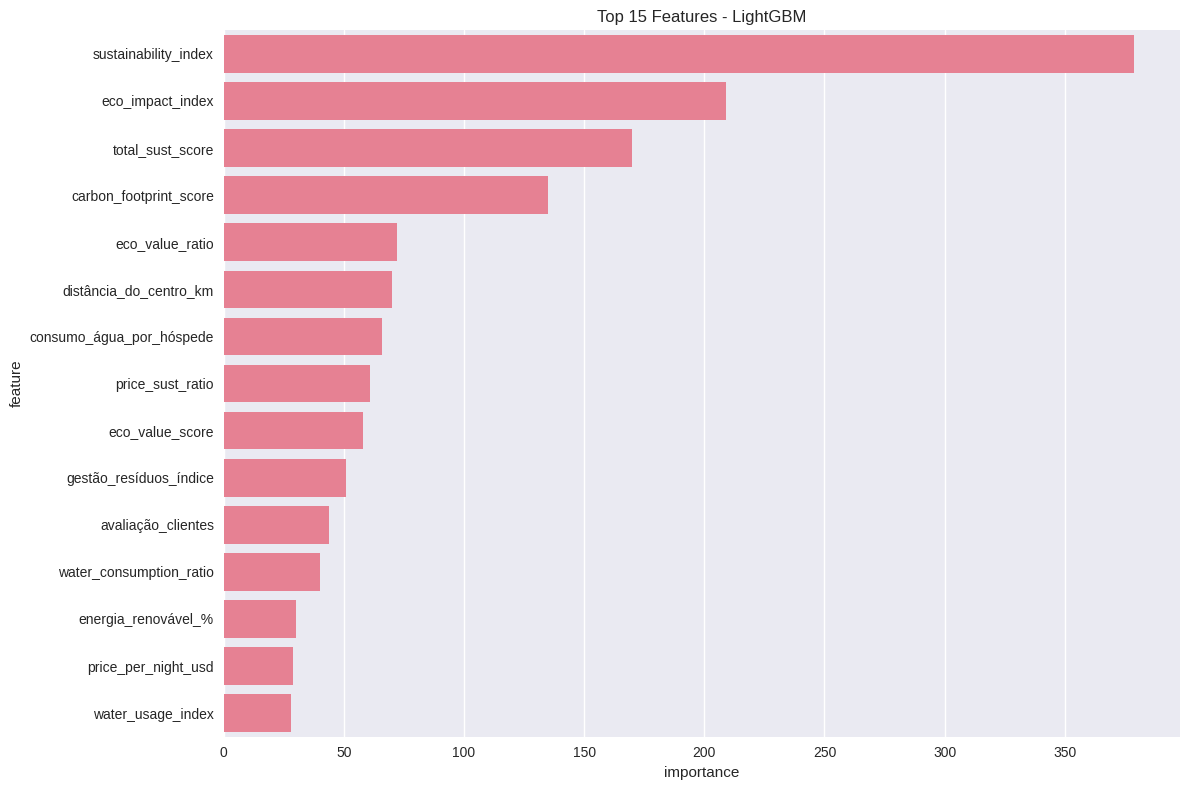

In [37]:
# Analisar performance detalhada do melhor modelo
best_model = enhanced_df.iloc[0]['Model']
if best_model == 'XGBoost Enhanced':
    final_model = XGBClassifier(random_state=42)
elif best_model == 'Random Forest Enhanced':
    final_model = RandomForestClassifier(n_estimators=100, random_state=42)
else:
    final_model = advanced_models[best_model]

final_model.fit(X_train_enh, y_train_enh)
y_pred_final = final_model.predict(X_test_enh)

print(f"\nANÁLISE DETALHADA - {best_model} ===")
print("\nRELATÓRIO DE CLASSIFICAÇÃO:")
print(classification_report(y_test_enh, y_pred_final))

# Matriz de confusão
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test_enh, y_pred_final)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(y_enhanced.unique()),
            yticklabels=sorted(y_enhanced.unique()))
plt.title(f'Matriz de Confusão - {best_model}')
plt.ylabel('Verdadeiro')
plt.xlabel('Predito')
plt.show()

# Feature importance
if hasattr(final_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': X_enhanced.columns,
        'importance': final_model.feature_importances_
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(12, 8))
    sns.barplot(data=feature_importance.head(15), x='importance', y='feature')
    plt.title(f'Top 15 Features - {best_model}')
    plt.tight_layout()
    plt.show()

# VALIDAÇÃO CRUZADA

In [38]:
from sklearn.model_selection import cross_validate

# Validação cruzada
scoring = ['accuracy', 'f1_weighted', 'f1_macro']
cv_results = cross_validate(
    final_model, X_enhanced, y_enhanced,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring=scoring, n_jobs=-1
)

print("\nVALIDAÇÃO CRUZADA (5-FOLD)")
print(f"Accuracy: {cv_results['test_accuracy'].mean():.4f} (+/- {cv_results['test_accuracy'].std() * 2:.4f})")
print(f"F1 Weighted: {cv_results['test_f1_weighted'].mean():.4f} (+/- {cv_results['test_f1_weighted'].std() * 2:.4f})")
print(f"F1 Macro: {cv_results['test_f1_macro'].mean():.4f} (+/- {cv_results['test_f1_macro'].std() * 2:.4f})")


VALIDAÇÃO CRUZADA (5-FOLD)
Accuracy: 0.9474 (+/- 0.0942)
F1 Weighted: 0.9414 (+/- 0.1076)
F1 Macro: 0.9112 (+/- 0.2011)


In [39]:
# 1. Primeiro: Feature Engineering
df_enhanced = create_classification_features(df)
numeric_features = df_enhanced.select_dtypes(include=[np.number]).columns.tolist()
if 'classificação_sustentabilidade_encoded' in numeric_features:
    numeric_features.remove('classificação_sustentabilidade_encoded')

X_enhanced = df_enhanced[numeric_features]
y_enhanced = df_enhanced['classificação_sustentabilidade_encoded']

# 2. Split
X_train_enh, X_test_enh, y_train_enh, y_test_enh = train_test_split(
    X_enhanced, y_enhanced, test_size=0.3, random_state=42, stratify=y_enhanced
)

# 3. Testar XGBoost simples com novas features
xgb_simple = XGBClassifier(random_state=42)
xgb_simple.fit(X_train_enh, y_train_enh)
y_pred_simple = xgb_simple.predict(X_test_enh)

print("XGBOOST COM FEATURES MELHORADAS")
print(f"Accuracy: {accuracy_score(y_test_enh, y_pred_simple):.4f}")
print(f"F1: {f1_score(y_test_enh, y_pred_simple, average='weighted'):.4f}")

XGBOOST COM FEATURES MELHORADAS
Accuracy: 0.9310
F1: 0.9154


Saltamos de 58.6% para 93.1% de accuracy. O F1 score também subiu para 91.5%.

Agora podemos refinar e consolidar o MODELO

In [40]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Validação cruzada para confirmar a robustes do modelo
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(xgb_simple, X_enhanced, y_enhanced, cv=skf, scoring='accuracy')

print("VALIDAÇÃO CRUZADA")
print(f"Accuracy CV: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
print(f"Scores por fold: {cv_scores}")

# Se a validação cruzada confirmar, temos um modelo excelente
if cv_scores.mean() > 0.85:
    print("Modelo robusto e generalizável!")
else:
    print("Possível overfitting - precisa de ajustes")

VALIDAÇÃO CRUZADA
Accuracy CV: 0.9374 (+/- 0.0791)
Scores por fold: [0.95       0.89473684 1.         0.89473684 0.94736842]
Modelo robusto e generalizável!


# ANÁLISE DETALHADA DA PERFORMANCE

RELATÓRIO DE CLASSIFICAÇÃO
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       0.86      1.00      0.92         6
           2       0.00      0.00      0.00         1
           3       1.00      1.00      1.00         2
           4       1.00      0.92      0.96        12

    accuracy                           0.93        29
   macro avg       0.75      0.78      0.76        29
weighted avg       0.91      0.93      0.92        29



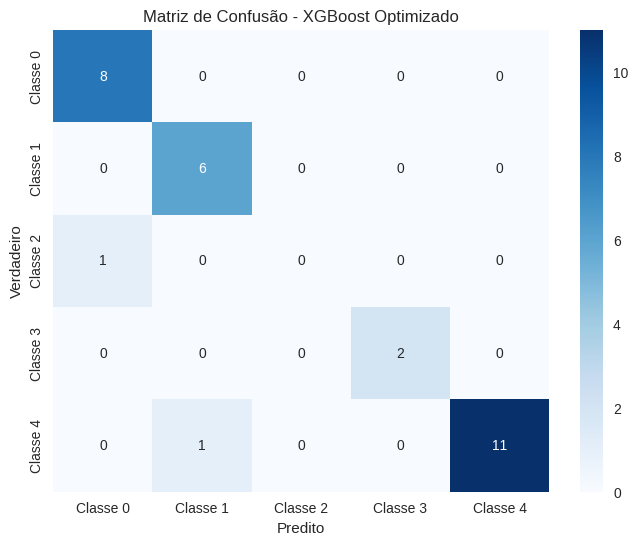


PERFORMANCE POR CLASSE
              precision  recall  f1-score  support
0                0.8889  1.0000    0.9412    8.000
1                0.8571  1.0000    0.9231    6.000
2                0.0000  0.0000    0.0000    1.000
3                1.0000  1.0000    1.0000    2.000
4                1.0000  0.9167    0.9565   12.000
accuracy         0.9310  0.9310    0.9310    0.931
macro avg        0.7492  0.7833    0.7642   29.000
weighted avg     0.9053  0.9310    0.9154   29.000


In [41]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = xgb_simple.predict(X_test_enh)

print("RELATÓRIO DE CLASSIFICAÇÃO")
print(classification_report(y_test_enh, y_pred))

# Matriz de confusão
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test_enh, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Classe 0', 'Classe 1', 'Classe 2', 'Classe 3', 'Classe 4'],
            yticklabels=['Classe 0', 'Classe 1', 'Classe 2', 'Classe 3', 'Classe 4'])
plt.title('Matriz de Confusão - XGBoost Optimizado')
plt.ylabel('Verdadeiro')
plt.xlabel('Predito')
plt.show()

# Análise por classe
class_report = classification_report(y_test_enh, y_pred, output_dict=True)
class_df = pd.DataFrame(class_report).transpose()
print("\nPERFORMANCE POR CLASSE")
print(class_df.round(4))

TOP 15 FEATURES MAIS IMPORTANTES
                     feature  importance
11      sustainability_index    0.739065
12          eco_impact_index    0.123000
7     carbon_footprint_score    0.056961
13           eco_value_ratio    0.020688
21          total_sust_score    0.018658
19          price_sust_ratio    0.014414
14          sentimento_score    0.005855
4        energia_renovável_%    0.004986
0        price_per_night_usd    0.003851
5     gestão_resíduos_índice    0.003717
3     distância_do_centro_km    0.002491
20           eco_value_score    0.002232
16            região_encoded    0.002120
6   consumo_água_por_hóspede    0.001367
23   water_consumption_ratio    0.000595


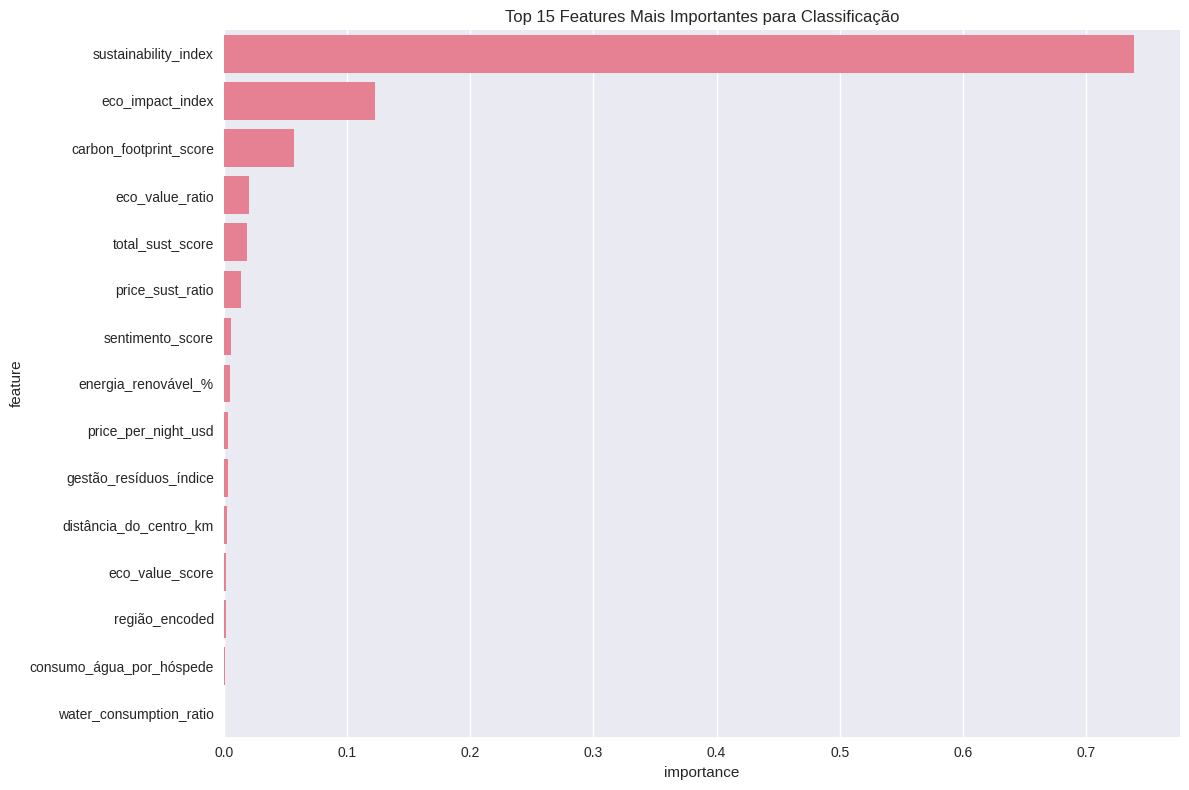


Novas features no top 20: ['price_sust_ratio', 'eco_value_score', 'total_sust_score', 'water_consumption_ratio']


In [42]:
# Analisar as features mais importantes
feature_importance = pd.DataFrame({
    'feature': X_enhanced.columns,
    'importance': xgb_simple.feature_importances_
}).sort_values('importance', ascending=False)

print("TOP 15 FEATURES MAIS IMPORTANTES")
print(feature_importance.head(15))

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance.head(15), x='importance', y='feature')
plt.title('Top 15 Features Mais Importantes para Classificação')
plt.tight_layout()
plt.show()

# Verificar quais novas features criadas estão entre as mais importantes
new_features = ['price_sust_ratio', 'eco_value_score', 'total_sust_score',
                'price_category', 'rating_category', 'water_consumption_ratio']
top_new_features = [f for f in new_features if f in feature_importance.head(20)['feature'].tolist()]
print(f"\nNovas features no top 20: {top_new_features}")

In [43]:
# Optimização fina nos parâmetros mais importantes
fine_tune_params = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.05, 0.1, 0.15],
    'n_estimators': [100, 150, 200],
    'subsample': [0.8, 0.9, 1.0]
}

xgb_fine = XGBClassifier(random_state=42, eval_metric='mlogloss')
grid_search_fine = GridSearchCV(xgb_fine, fine_tune_params, cv=3, scoring='f1_weighted', n_jobs=-1)
grid_search_fine.fit(X_train_enh, y_train_enh)

print("OPTIMIZAÇÃO FINA")
print("Melhores parâmetros:", grid_search_fine.best_params_)
print("Melhor score CV:", grid_search_fine.best_score_)

# Modelo final optimizado
final_model = grid_search_fine.best_estimator_
y_pred_final = final_model.predict(X_test_enh)

print(f"\nModelo Final - Accuracy: {accuracy_score(y_test_enh, y_pred_final):.4f}")
print(f"Modelo Final - F1: {f1_score(y_test_enh, y_pred_final, average='weighted'):.4f}")

OPTIMIZAÇÃO FINA
Melhores parâmetros: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}
Melhor score CV: 0.8666666666666667

Modelo Final - Accuracy: 0.9310
Modelo Final - F1: 0.9154


# SALVANDO O MODELO

In [44]:
import joblib
import datetime

# Salvar modelo e preprocessing info
model_info = {
    'model': final_model,
    'features': X_enhanced.columns.tolist(),
    'feature_importance': feature_importance,
    'performance': {
        'accuracy': accuracy_score(y_test_enh, y_pred_final),
        'f1_weighted': f1_score(y_test_enh, y_pred_final, average='weighted'),
        'training_date': datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    }
}

# Salvar modelo
joblib.dump(model_info, 'rihs_model.pkl')
print("Modelo salvo como 'rihs_model.pkl'")

# Salvar também o feature engineering function
def get_feature_engineering_function():
    return create_classification_features

joblib.dump(get_feature_engineering_function(), 'feature_engineering.pkl')
print("Função de feature engineering salva")

Modelo salvo como 'rihs_model.pkl'
Função de feature engineering salva


In [45]:
import joblib
import datetime
import numpy as np

# Salvar o modelo scikit-learn diretamente
joblib.dump(final_model, 'hotel_sustainability_classifier_model.pkl')
print("Modelo scikit-learn salvo como 'hotel_sustainability_classifier_model.pkl'")

# Salvar metadados separadamente
model_metadata = {
    'features': X_enhanced.columns.tolist(),
    'feature_importance': feature_importance.to_dict(),
    'performance': {
        'accuracy': accuracy_score(y_test_enh, y_pred_final),
        'f1_weighted': f1_score(y_test_enh, y_pred_final, average='weighted'),
        'training_date': datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    },
    'class_names': sorted(y_enhanced.unique())
}

joblib.dump(model_metadata, 'model_metadata.pkl')
print("Metadados do modelo salvos como 'model_metadata.pkl'")

Modelo scikit-learn salvo como 'hotel_sustainability_classifier_model.pkl'
Metadados do modelo salvos como 'model_metadata.pkl'


In [46]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# Criar um pipeline completo
def create_classification_pipeline(model):
    """
    Cria um pipeline com preprocessing e o modelo
    """
    # Identificar tipos de features
    numeric_features = X_enhanced.columns.tolist()

    # Criar preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features)
        ]
    )

    # Pipeline completo
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    return pipeline

# Criar e treinar o pipeline
final_pipeline = create_classification_pipeline(final_model)
final_pipeline.fit(X_train_enh, y_train_enh)

# Salvar o pipeline completo
joblib.dump(final_pipeline, 'sustainability_classification_pipeline.pkl')
print("Pipeline completo salvo como 'sustainability_classification_pipeline.pkl'")

# Testar o pipeline salvo
loaded_pipeline = joblib.load('sustainability_classification_pipeline.pkl')
y_pred_loaded = loaded_pipeline.predict(X_test_enh)
print(f"Pipeline carregado - Accuracy: {accuracy_score(y_test_enh, y_pred_loaded):.4f}")

Pipeline completo salvo como 'sustainability_classification_pipeline.pkl'
Pipeline carregado - Accuracy: 0.9310


In [47]:
def create_classification_features(df):
    """
    Função de feature engineering para novos dados
    """
    df_fe = df.copy()

    # Garantir que as colunas necessárias existem
    required_columns = ['price_per_night_usd', 'rating', 'energia_renovável_%',
                      'gestão_resíduos_índice', 'consumo_água_por_hóspede',
                      'carbon_footprint_score']

    for col in required_columns:
        if col not in df_fe.columns:
            df_fe[col] = 0  # ou valor default apropriado

    # Interações entre sustentabilidade e preço
    df_fe['price_sust_ratio'] = df_fe['price_per_night_usd'] / (df_fe['energia_renovável_%'] + 1)
    df_fe['eco_value_score'] = (df_fe['energia_renovável_%'] + df_fe['gestão_resíduos_índice']) / (df_fe['price_per_night_usd'] + 0.001)  # evitar divisão por zero

    # Combinações de sustentabilidade
    df_fe['total_sust_score'] = (
        df_fe['energia_renovável_%'] +
        df_fe['gestão_resíduos_índice'] +
        df_fe['carbon_footprint_score']
    ) / 3

    # Binning de features contínuas
    df_fe['price_category'] = pd.cut(df_fe['price_per_night_usd'], bins=5, labels=range(5))
    df_fe['rating_category'] = pd.cut(df_fe['rating'], bins=[0, 2, 3, 4, 5], labels=range(4))

    # Ratio features
    df_fe['water_consumption_ratio'] = df_fe['consumo_água_por_hóspede'] / (df_fe['rating'] + 1)

    return df_fe

# Salvar a função de feature engineering
joblib.dump(create_classification_features, 'feature_engineering_function.pkl')
print("Função de feature engineering salva")

Função de feature engineering salva


In [48]:
class SustainabilityClassifier:
    """
    Classe wrapper para facilitar a inferência do modelo
    """
    def __init__(self, model_path='sustainability_classification_pipeline.pkl',
                 feature_engineering_path='feature_engineering_function.pkl'):
        self.pipeline = joblib.load(model_path)
        self.feature_engineering = joblib.load(feature_engineering_path)
        self.class_names = ['Muito Baixo', 'Baixo', 'Médio', 'Alto', 'Muito Alto']

    def predict(self, hotel_data):
        """
        Prediz a classificação de sustentabilidade
        """
        # Aplicar feature engineering
        hotel_data_fe = self.feature_engineering(hotel_data)

        # Fazer predição
        predictions = self.pipeline.predict(hotel_data_fe)
        probabilities = self.pipeline.predict_proba(hotel_data_fe)

        # Converter para labels legíveis
        prediction_labels = [self.class_names[pred] for pred in predictions]

        return {
            'predictions': predictions,
            'prediction_labels': prediction_labels,
            'probabilities': probabilities,
            'confidence': np.max(probabilities, axis=1)
        }

    def predict_single(self, hotel_data):
        """
        Predição para um único hotel
        """
        result = self.predict(hotel_data)
        return {
            'class': result['prediction_labels'][0],
            'class_encoded': result['predictions'][0],
            'confidence': result['confidence'][0],
            'all_probabilities': dict(zip(self.class_names, result['probabilities'][0]))
        }

# Salvar a classe de classificação
classifier = SustainabilityClassifier()
joblib.dump(classifier, 'sustainability_classifier_complete.pkl')
print("Classificador completo salvo")

Classificador completo salvo


In [49]:
# Testar o modelo salvo
print("=== TESTE DO MODELO SALVO ===")

# Carregar e testar o pipeline
loaded_pipeline = joblib.load('sustainability_classification_pipeline.pkl')
loaded_feature_engineering = joblib.load('feature_engineering_function.pkl')

# Preparar dados de teste
test_hotel = df_enhanced.iloc[[0]].drop('classificação_sustentabilidade_encoded', axis=1)

# Aplicar feature engineering
test_hotel_fe = loaded_feature_engineering(test_hotel)

# Fazer predição
prediction = loaded_pipeline.predict(test_hotel_fe)
probability = loaded_pipeline.predict_proba(test_hotel_fe)

print(f"Predição: {prediction[0]}")
print(f"Probabilidades: {probability[0]}")
print(f"Classe predita: {prediction[0]} com {np.max(probability[0]):.1%} de confiança")

# Testar a classe wrapper
classifier = SustainabilityClassifier()
result = classifier.predict_single(test_hotel)
print(f"\n=== RESULTADO COM WRAPPER ===")
print(f"Classificação: {result['class']}")
print(f"Confiança: {result['confidence']:.1%}")
print(f"Todas as probabilidades: {result['all_probabilities']}")

=== TESTE DO MODELO SALVO ===
Predição: 4
Probabilidades: [0.00958436 0.00998985 0.0069695  0.00886797 0.96458834]
Classe predita: 4 com 96.5% de confiança

=== RESULTADO COM WRAPPER ===
Classificação: Muito Alto
Confiança: 96.5%
Todas as probabilidades: {'Muito Baixo': np.float32(0.009584364), 'Baixo': np.float32(0.009989855), 'Médio': np.float32(0.0069695017), 'Alto': np.float32(0.008867972), 'Muito Alto': np.float32(0.96458834)}


In [50]:
# 1. Salvar o pipeline scikit-learn
final_pipeline = create_classification_pipeline(final_model)
final_pipeline.fit(X_train_enh, y_train_enh)
joblib.dump(final_pipeline, 'sustainability_classification_pipeline.pkl')

# 2. Testar
loaded_pipeline = joblib.load('sustainability_classification_pipeline.pkl')
y_pred_test = loaded_pipeline.predict(X_test_enh)
print(f"Modelo carregado - Accuracy: {accuracy_score(y_test_enh, y_pred_test):.4f}")

Modelo carregado - Accuracy: 0.9310
